In [1]:
import sys,os
import numpy as np
import pandas as pd
import time, datetime
import random
import argparse
import math

import matplotlib.pyplot as plt


%matplotlib inline

### Modifications
 * pre-clustering of binary matrix reduces initial number of gene clusters
 * create UP- and DOWN- regulated matrice when run GMM binarization

In [2]:
min_n_samples = -1
alpha = 1.0
beta_K = 1.0
snr_pval = 0.05 
f = 0.25 # min % of time in a module

# convergence
max_n_steps= 100
n_steps_averaged = 20
n_steps_for_convergence = 10
min_pletau_steps = 20
n_points_fit=10

verbose = True
plot_all = True

out_dir = os.getcwd()+"/tmp_results/"
basename = "TCGA-micro_13K"
seed = 42


#exprs_file = "../../DESMOND/simulated_datasets_backup2/exprs/simulated.N=10.Mu=2.0.GxP=100,100.overlap=TT.exprs.tsv"
#network_file = "../../DESMOND/simulated_datasets_backup2/networks/simulated.N=10.Mu=2.0.GxP=100,100.overlap=TT.tab"
#network_file = "/home/olya/SFU/Breast_cancer/DESMOND/BioGrid_human.tab"
#exprs_file = "../../Expression/Harmonized_final/TCGA_RNAseq.RSEM.log2.z.13K_common.tsv"
root = "/home/olya/SFU/Breast_cancer/"


#exprs_file = "../datasets/METABRIC_1904.nolog2_exprs_z.tsv"
#exprs_file = "../datasets/METABRIC_299TNBC.nolog2_exprs_z.tsv"
#exprs_file = "../datasets/TCGA-BRCA_139TNBC.Xena.log2RSEM_norm_z.24K_genes.tsv"
#exprs_file = "../datasets/TCGA-BRCA_945.Xena.log2RSEM_norm_z.24K_genes.tsv"
exprs_file = root+"/Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"

In [3]:
start_time = time.time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
if verbose:
    print("Will save output files to:",out_dir + basename + "*", file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# define minimal number of patients in a module
if min_n_samples == -1:
    min_n_samples = int(max(5,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
if verbose:
    print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)

Will save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-micro_13K*
Mininal number of samples in a module: 26


# 0) Find the trend between SNR and bicluster size

1) generate random splits for all bicluster sizes [min_n_samples, N/2]

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.05

get_snr_thr is a function of bicluser size 


In [4]:
from method2 import rand_norm_splits, get_trend

In [5]:
s25,t25 = rand_norm_splits(25)
s50,t50 = rand_norm_splits(50)
s100,t100 = rand_norm_splits(100)
s1,t1 = rand_norm_splits(200)
s2,t2 = rand_norm_splits(500)
s3,t3 = rand_norm_splits(1000)
s4,t4 = rand_norm_splits(2000)
plt.plot(s25/25,t25,label='N=25',color="cyan")
plt.plot(s50/50,t50,label='N=50',color="blue")
plt.plot(s100/100,t100,label='N=100',color="red")
plt.plot(s1/200,t1,label='N=200',color="green")
plt.plot(s2/500,t2,label='N=500',color="orange")
plt.plot(s3/1000,t3,label='N=1000',color="magenta")
plt.plot(s4/2000,t4,label='N=2000',color="black")
tmp = plt.legend()

total samples: 25, min_n_samples: 5, n_permutations: 4000


KeyboardInterrupt: 

total samples: 529, min_n_samples: 26, n_permutations: 189


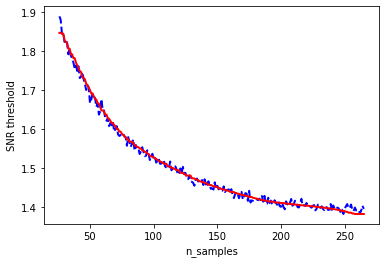

In [7]:
sizes,thresholds = rand_norm_splits(exprs.shape[1], snr_pval = snr_pval,seed=seed)
get_min_snr = get_trend(sizes,thresholds, plot = plot_all)

# 1) Assign patients to edges
 * GMM
 * filtering by sample nubmer and SNR

		genes processed: 0
Gene SIDT1: SNR=2.03, pos=0, neg=92


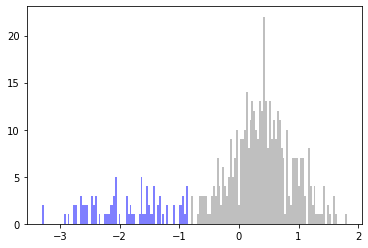

Gene CLIC6: SNR=-2.01, pos=186, neg=0


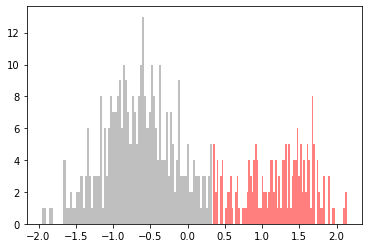

		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
Gene GRB7: SNR=2.56, pos=53, neg=0


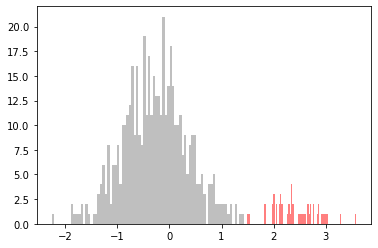

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.21, pos=0, neg=134


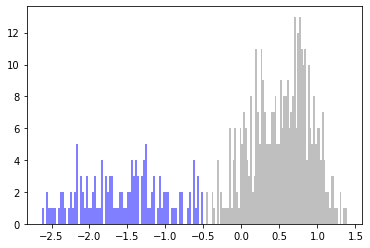

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=2.19, pos=57, neg=0


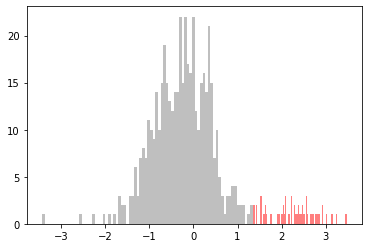

Gene GATA3: SNR=1.73, pos=0, neg=125


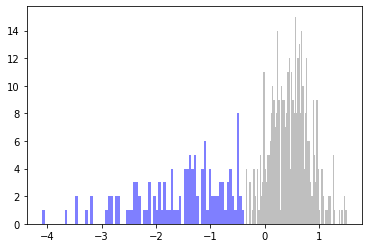

		genes processed: 9000
Gene FOXA1: SNR=2.57, pos=0, neg=94


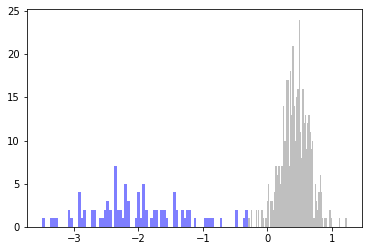

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=-2.16, pos=241, neg=288


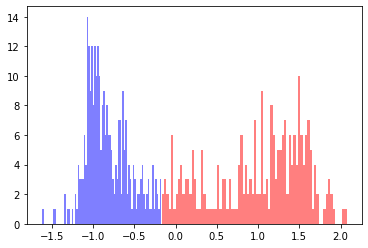

		genes processed: 12000
		genes processed: 13000
Total runtime 115.43 s for  13361 genes
	up-regulated genes: 1563
	down-regulated genes: 1012
	inexplicit genes: 378


In [10]:
from method2 import GM_binarization
sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
binarized_expressions = GM_binarization(exprs,get_min_snr,min_n_samples,verbose = True, 
                                        plot=True, plot_SNR_thr= 3.0, show_fits = sele_genes,seed = seed)


In [10]:
# save to file binarized genes
sample_names = exprs.columns
for d in ["UP","DOWN"]:
    df = binarized_expressions[d]
    df.index = sample_names
    suffix  = ".pv="+str(snr_pval)+",direction="+d
    fname = out_dir+"/"+basename+ suffix +".bin_exprs.tsv"
    print(fname)
    df.to_csv(fname, sep ="\t")

/home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-micro_13K.pv=0.05,direction=UP.bin_exprs.tsv
/home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-micro_13K.pv=0.05,direction=DOWN.bin_exprs.tsv


In [6]:
# load from file binarized genes
binarized_expressions = {}

for d in ["UP","DOWN"]:
    suffix  = ".pv="+str(snr_pval)+",direction="+d
    fname = out_dir+"/"+basename+ suffix +".bin_exprs.tsv"
    print(fname)
    df = pd.read_csv(fname, sep ="\t",index_col=0)
    df.index = range(0,df.shape[0])
    binarized_expressions[d] = df

/home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-micro_13K.pv=0.05,direction=UP.bin_exprs.tsv
/home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-micro_13K.pv=0.05,direction=DOWN.bin_exprs.tsv


# Step 2. Sample module memberships

In [33]:
from method2 import set_initial_conditions, sampling, get_consensus_modules

In [34]:
direction = "UP"
exprs_bin = binarized_expressions[direction]
print(exprs_bin.shape)
exprs_bin.columns

(529, 1563)


Index(['ASS1', 'ZNF707', 'CEACAM5', 'NUP93', 'SP5', 'GTSE1', 'UGCG', 'ITGA7',
       'FBXL13', 'SDK1',
       ...
       'RGS13', 'LANCL3', 'IGFL2', 'ELF5', 'CAND2', 'LDHB', 'LDHC', 'SLC7A10',
       'FOLR1', 'GNGT1'],
      dtype='object', length=1563)

In [35]:
# simplifying probability calculations
N = exprs.shape[1]
max_log_float = np.log(np.finfo(np.float64).max)
n_exp_orders = 7 # ~1000 times 
p0 = N*np.log(0.5)+np.log(beta_K)
match_score = np.log((alpha*0.5+1)/(alpha))
mismatch_score = np.log((alpha*0.5+0)/alpha)
bK_1 = math.log(1+beta_K)
genes = exprs_bin.columns.values

In [36]:
print("Direction:",direction)
moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = True)
K = len(moduleSizes)
N = gene2Samples.shape[1]
print("\t\tLP memory, {:.2f} M".format(LP.nbytes/(1024*1024)),file = sys.stdout)


Direction: UP
		KxN=1563x529
		p0= -366.67485851621103
	 1000 genes processed in  2.3 s
time:	Initial state created in 2.6 s.
		LP memory, 18.64 M


In [37]:
n_steps_averaged

20

In [38]:
t0 = time.time()
gene2Module_history,n_final_steps,n_skipping_genes,P_diffs = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score, bK_1, alpha, beta_K, 
                                                                          max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, tol = 0.1, 
                                                                          n_steps_for_convergence = n_steps_for_convergence, verbose=True)

print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time.time()-t0,2)), file = sys.stdout)


step 1
1000 		genes processed in 7.8 s runtime...
	step  1 12.8 s
step 2
1000 		genes processed in 5.2 s runtime...
	step  2 8.3 s
step 3
1000 		genes processed in 4.3 s runtime...
	step  3 7.3 s
step 4
1000 		genes processed in 2.7 s runtime...
	step  4 4.7 s
step 5
1000 		genes processed in 2.1 s runtime...
	step  5 4.4 s
step 6
1000 		genes processed in 2.1 s runtime...
	step  6 3.6 s
step 7
1000 		genes processed in 1.7 s runtime...
	step  7 3.4 s
step 8
1000 		genes processed in 1.7 s runtime...
	step  8 3.7 s
step 9
1000 		genes processed in 1.7 s runtime...
	step  9 2.9 s
step 10
1000 		genes processed in 1.6 s runtime...
	step  10 2.9 s
step 11
1000 		genes processed in 1.6 s runtime...
	step  11 3.0 s
step 12
1000 		genes processed in 1.7 s runtime...
	step  12 3.1 s
step 13
1000 		genes processed in 2.0 s runtime...
	step  13 3.3 s
step 14
1000 		genes processed in 2.1 s runtime...
	step  14 3.7 s
step 15
1000 		genes processed in 2.0 s runtime...
	step  15 3.4 s
step 16
1000

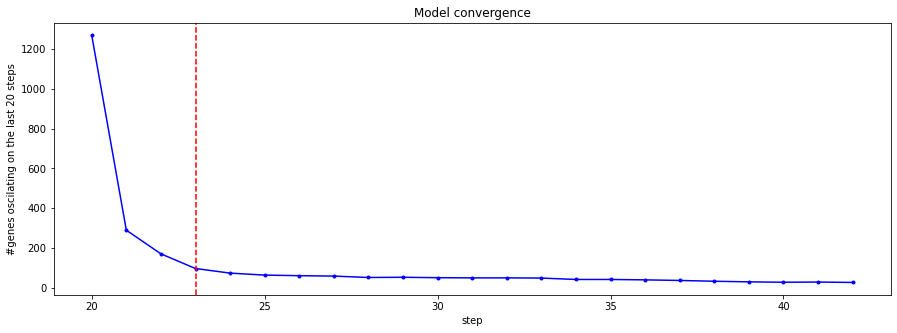

In [39]:
if plot_all:
    from method2 import plot_convergence
    plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
    plot_convergence(n_skipping_genes, P_diffs,len(gene2Module_history)-n_final_steps,
                     n_steps_averaged, outfile=plot_outfile)


In [40]:
#n_final_steps = 100
n_final_steps

20

In [41]:
consensus = get_consensus_modules(gene2Module_history[-n_final_steps:])


Gene 440 -> [819,824]
440 : [819 824] [0.75 0.25]
Gene 959 -> [1153,1253]
959 : [1153 1253] [0.45 0.55]
Gene 1103 -> [844,1041,1392]
1103 : [ 844 1041 1392] [0.25 0.3  0.45]
Gene 1261 -> [1204,1270]
1261 : [ 918 1204 1270] [0.05 0.3  0.65]
Gene 1337 -> [1176,1337]
1337 : [1176 1337] [0.4 0.6]
Gene 1339 -> [1204,1370]
1339 : [ 870 1204 1339 1370] [0.15 0.55 0.05 0.25]
Gene 1356 -> [286,693]
1356 : [286 693] [0.75 0.25]
Gene 1422 -> [1100,1558]
1422 : [1100 1558] [0.55 0.45]
Gene 1452 -> [530,693]
1452 : [530 693] [0.35 0.65]
Gene 1462 -> [152,1558]
1462 : [ 152 1558] [0.55 0.45]
Gene 1507 -> [152,826]
1507 : [152 826] [0.45 0.55]
Gene 1556 -> [819,1392]
1556 : [ 819 1392] [0.5 0.5]
Gene 1559 -> [1100,1176]
1559 : [1100 1176] [0.4 0.6]

size(genes)	n_modules
0 		 955
1 		 108
2 		 481
3 		 25
4 		 4
5 		 3
6 		 1
7 		 1
8 		 4
9 		 1
13 		 1
22 		 2
27 		 1
56 		 1
62 		 1
186 		 1


# 3) Define biclusters

In [42]:
from method2 import genesets2biclusters,  write_bic_table

In [43]:
exprs_np = exprs.loc[genes,:]
ints2g_names = exprs_np.index.values
ints2s_names = exprs_np.columns.values
exprs_np = exprs_np.values
exprs_sums = exprs_np.sum(axis=1)
exprs_sq_sums = np.square(exprs_np).sum(axis=1)
N = exprs.shape[1]
exprs_data = N, exprs_sums, exprs_sq_sums

In [44]:
filtered_bics = genesets2biclusters(consensus, exprs_np, exprs_data,ints2g_names,ints2s_names,
                        min_SNR = 0,direction=direction,min_n_samples=min_n_samples, min_n_genes=2,
                        verbose = verbose)

time:	Identified optimal sample sets for 1590 modules in 13.98 s.
Passed biclusters (>=26 genes, > 0 SNR): 527
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

8x232	0.883	AP1G1 APRT DDX28 DHODH KATNB1 NIP7 NUDT21 SF3B3
3x192	0.85	CEBPB GRB14 KCNK5
6x143	1.074	KYNU LBP S100A7 S100A7A S100A8 S100A9
3x214	0.947	KCNE4 MRPS30 UGCG
3x249	1.267	CRTAM SAMD3 SLAMF1
3x185	0.773	AMDHD1 CBLN2 NOVA1
8x198	1.017	ADCK5 BOP1 COMMD5 HSF1 PUF60 SCRIB TOP1MT ZNF707
5x213	1.188	HIST1H1C HIST1H1E HIST1H2AM HIST1H3H HIST1H4H
4x158	0.841	AK5 EFCAB1 IL17B KCNE1
8x151	1.169	CD19 CD79A FCRL5 IGLL1 IRF4 KRT81 PKHD1L1 PNOC
3x261	1.488	C10orf82 HSPA12A SYT1
3x203	0.695	C8orf4 NRXN3 STEAP4
22x211	1.099	AIM2 BTLA CCR2 CD200R1 CD38 CD7 CTSW EOMES ICOS IFNG IL2RG KLHL6 LY9 PDCD1 PTPN7 PTPRCAP PYHIN1 SH2D1A SLA2 SLAMF7 TRAT1 XCL1
3x220	1.531	C6 CIDEA MRAP
7x202	0.953	FAT2 KCNJ16 OSR1 PAK7 SAMD5 SFRP1 TSLP
3x157	1.017	ARL9 CEBPB LRP8
3x165	1.275	GSTM1 GSTM2 GSTM5
22x124	0.935

In [32]:
filtered_bics = genesets2biclusters(consensus, exprs_np, exprs_data,ints2g_names,ints2s_names,
                        min_SNR = 0,direction=direction,min_n_samples=min_n_samples, min_n_genes=2,
                        verbose = verbose)

time:	Identified optimal sample sets for 1604 modules in 14.07 s.
Passed biclusters (>=26 genes, > 0 SNR): 533
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

8x232	0.883	AP1G1 APRT DDX28 DHODH KATNB1 NIP7 NUDT21 SF3B3
4x131	1.401	S100A7 S100A7A S100A8 S100A9
4x281	1.249	AURKA TPX2 TROAP UBE2C
8x198	1.017	ADCK5 BOP1 COMMD5 HSF1 PUF60 SCRIB TOP1MT ZNF707
3x145	0.878	ETV4 KCNG1 KIF1A
5x213	1.188	HIST1H1C HIST1H1E HIST1H2AM HIST1H3H HIST1H4H
29x193	1.012	AIM2 BTLA CD19 CD200R1 CD7 CD79A CTSW EOMES FCRL5 GRIN3A ICOS IFNG IL2RG IRF4 KLHL6 KLRD1 KRT81 LY9 PDCD1 PKHD1L1 PNOC PRF1 PTPN7 PTPRCAP PYHIN1 SH2D1A SLA2 TRAT1 XCL1
3x252	0.915	ADCY5 F7 HPX
3x280	0.623	CNTNAP2 F7 HOXB4
191x102	0.754	AADAT ABCC4 ACE2 ACTR3B ADD2 ALX3 ANKS6 APCDD1L ARL9 ARNTL2 ART3 ATOH7 ATP11A ATP6V1C2 B3GAT1 B3GNT5 BNC1 C11orf16 C12orf56 C1QL2 C21orf91 C8orf46 CA9 CALCB CCDC67 CCKBR CCNE1 CDH19 CDK6 CDKN2A CEBPG CHODL CHRM3 CHST2 CHST4 CIB2 CIB4 CPA4 CSN3 CSTA DLX5 DLX6 DMRT

In [16]:
result_file_name = out_dir+basename+suffix
write_bic_table(filtered_bics,
                result_file_name+".biclusters.tsv")


print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)
print(result_file_name)

Total runtime: 253.07
/home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-micro_13K.pv=0.05,direction=DOWN


# All steps in one function

In [1]:
import sys,os
import numpy as np
import pandas as pd
import time, datetime
import random
import argparse
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from method2 import rand_norm_splits, get_trend, GM_binarization
from method2 import set_initial_conditions, sampling, get_consensus_modules
from method2 import genesets2biclusters,  write_bic_table

In [3]:
def run_DESMOND(exprs_file, out_dir = "./",basename = False,
                min_n_samples = -1,
                alpha=1.0 ,beta_K=1.0, snr_pval = 0.05,
                max_n_steps= 200, n_steps_averaged = 20, n_steps_for_convergence = 5, n_points_fit=10,
                plot_all=True, verbose = True, seed= 42):
    
    biclusters = {} # UP and DOWN
    start_time = time.time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 

    suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)
    if verbose:
        print("Will save output files to: %s*."% (out_dir + basename + suffix), file = sys.stdout)

    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

    # define minimal number of patients in a module
    if min_n_samples == -1:
        min_n_samples = int(max(5,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
    if verbose:
        print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)
    
    #### Computing min_SNR(size) ###
    sizes,thresholds = rand_norm_splits(exprs.shape[1], snr_pval = snr_pval,seed=seed)
    get_min_snr = get_trend(sizes,thresholds, plot = plot_all)
    
    ####1. Binarization ####
    sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
    binarized_expressions = GM_binarization(exprs,get_min_snr,min_n_samples,verbose = True, 
                                        plot=True, plot_SNR_thr= 3.0, show_fits = sele_genes,seed = seed)    
    ### 2. Edge clustering ###
    
    # simplifying probability calculations
    N = exprs.shape[1]
    max_log_float = np.log(np.finfo(np.float64).max)
    n_exp_orders = 7 # ~1000 times 
    p0 = N*np.log(0.5)+np.log(beta_K)
    match_score = np.log((alpha*0.5+1)/(alpha))
    mismatch_score = np.log((alpha*0.5+0)/alpha)
    bK_1 = math.log(1+beta_K)
    
    i = 0
    for direction in ["UP","DOWN"]:
        t1 = time.time()
        exprs_bin = binarized_expressions[direction]
        genes = exprs_bin.columns.values
        # setting initial model state
        print("Searching for %s-regulated biclusters ..."%direction)
        moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = verbose)
        K = len(moduleSizes)
        N = gene2Samples.shape[1]
        print("\t\tLP matrix memory usage: {:.2f}M".format(LP.nbytes/(1024*1024)),file = sys.stdout)

        # sampling
        t0 = time.time()
        gene2Module_history,n_final_steps,n_skipping_genes,P_diffs = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,
                                                                              moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score,
                                                                              bK_1, alpha, beta_K, max_n_steps=max_n_steps, tol = 0.1,
                                                                              n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, 
                                                                              n_steps_for_convergence = n_steps_for_convergence, verbose=True)

        print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time.time()-t0,2)), file = sys.stdout)
        if plot_all:
            from method2 import plot_convergence
            plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
            plot_convergence(n_skipping_genes, P_diffs,len(gene2Module_history)-n_final_steps,
                             n_steps_averaged, outfile=plot_outfile)

        # take the last (n_points_fit+n_steps_for_convergence) steps modules:
        # and get consensus edge-to-module membership
        consensus, nOnesPerSampleInModules, moduleSizes, moduleOneFreqs = get_consensus_modules(gene2Module_history[-n_final_steps:], 
                                                                                                LP, gene2Samples, gene2Module,
                                                                                                nOnesPerSampleInModules,moduleSizes, 
                                                                                                moduleOneFreqs, p0, 
                                                                                                match_score,mismatch_score,
                                                                                                bK_1,alpha,beta_K,N,K)

        print("\tEmpty modules:", len([x for x in moduleSizes if x == 0]),
              "\n\tNon-empty modules:",len([x for x in moduleSizes if x > 0]),file = sys.stdout)
        #### 3. Define biclusters and merge modules  ####
        exprs_np = exprs.loc[genes,:]
        ints2g_names = exprs_np.index.values
        ints2s_names = exprs_np.columns.values
        exprs_np = exprs_np.values
        exprs_sums = exprs_np.sum(axis=1)
        exprs_sq_sums = np.square(exprs_np).sum(axis=1)
        N = exprs.shape[1]
        exprs_data = N, exprs_sums, exprs_sq_sums
        # Identify optimal patient sets for each module: split patients into two sets in a subspace of each module
        # Filter out bad biclusters with too few genes or samples, or with low SNR
        filtered_bics = genesets2biclusters(exprs_np, exprs_data,moduleSizes,consensus,
                                min_SNR = 0.5,direction=direction,min_n_samples=min_n_samples,
                                verbose = verbose)
        # print info on found biclusters
        if verbose:
            for bic in filtered_bics:
                bic["id"] = i
                i+=1
                bic["genes"] = sorted([ints2g_names[x] for x in bic["genes"]])
                bic["samples"] = sorted([ints2s_names[x] for x in bic["samples"]])
                if len(bic["genes"])>2:
                    print("\t".join(map(str,[str(bic["n_genes"])+"x"+str(bic["n_samples"]),
                                             round(bic["avgSNR"],3)," ".join(bic["genes"])])),file = sys.stdout)
                        
        # save results 
        result_file_name = out_dir+basename+suffix+",direction="+direction
        write_bic_table(filtered_bics,result_file_name+".biclusters.tsv")
        if verbose:
            print("Runtime for %s-regulated biclusters: %s"%(direction, round(time.time()-t1,2)),file = sys.stdout)
        biclusters[direction] = filtered_bics
    
    biclusters = biclusters["UP"] + biclusters["DOWN"]
    result_file_name = out_dir+basename+suffix
    write_bic_table(biclusters,result_file_name+".biclusters.tsv")
    if verbose:
        print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)
        
    return biclusters


max_n_steps= 200
n_steps_averaged = 20
n_steps_for_convergence = 5
min_pletau_steps = 20
n_points_fit=10
seed = 42

#snr_pval = 0.05
snr_pval = 0.01

out_dir = "tmp_results/"

Will save output files to: ./results_17:13_2021-07-13.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 26
total samples: 529, min_n_samples: 26, n_permutations: 189
		genes processed: 0
Gene SIDT1: SNR=2.03, pos=0, neg=92


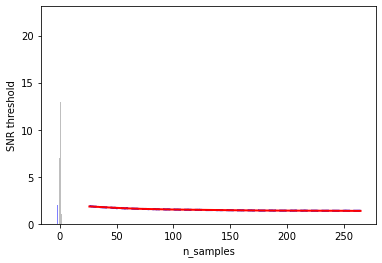

Gene CLIC6: SNR=-2.01, pos=186, neg=0


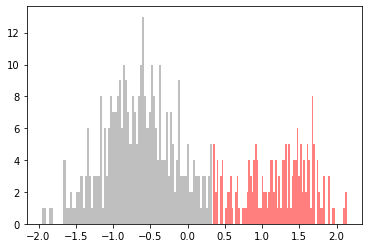

		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
Gene GRB7: SNR=2.56, pos=53, neg=0


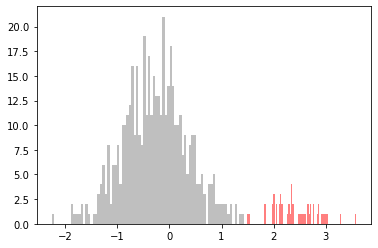

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.21, pos=0, neg=134


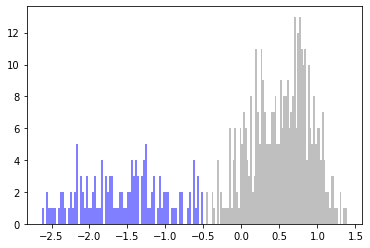

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=2.19, pos=57, neg=0


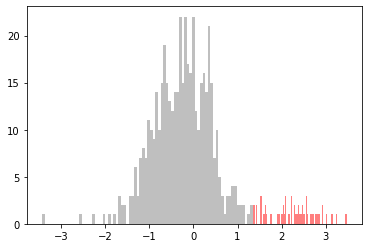

Gene GATA3: SNR=1.73, pos=0, neg=125


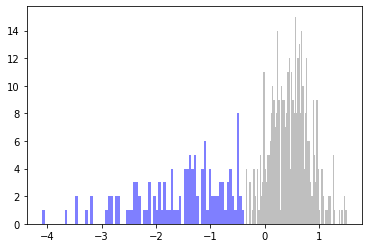

		genes processed: 9000
Gene FOXA1: SNR=2.57, pos=0, neg=94


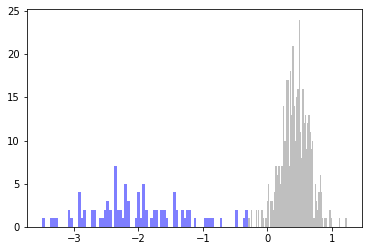

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=-2.16, pos=241, neg=288


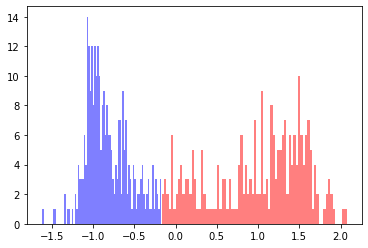

		genes processed: 12000
		genes processed: 13000
Total runtime 156.5 s for  13361 genes
	up-regulated genes: 1563
	down-regulated genes: 1012
	inexplicit genes: 378
Searching for UP-regulated biclusters ...
		KxN=1563x529
		p0= -366.67485851621103
	 1000 genes processed in  6.8 s
time:	Initial state created in 7.4 s.
		LP matrix memory usage: 18.64M
step 1
1000 		genes processed in 36.5 s runtime...
	step  1 51.5 s
step 2
1000 		genes processed in 8.0 s runtime...
	step  2 15.6 s
step 3
1000 		genes processed in 6.5 s runtime...
	step  3 10.3 s
step 4
1000 		genes processed in 3.7 s runtime...
	step  4 6.9 s
step 5
1000 		genes processed in 2.6 s runtime...
	step  5 4.7 s
step 6
1000 		genes processed in 2.3 s runtime...
	step  6 4.7 s
step 7
1000 		genes processed in 2.7 s runtime...
	step  7 5.4 s
step 8
1000 		genes processed in 2.5 s runtime...
	step  8 4.4 s
step 9
1000 		genes processed in 3.1 s runtime...
	step  9 5.6 s
step 10
1000 		genes processed in 2.4 s runtime...
	step  

1000 		genes processed in 1.8 s runtime...
	step  20 1.8 s
step 21
1000 		genes processed in 1.7 s runtime...
	step  21 1.8 s
step 22
1000 		genes processed in 1.4 s runtime...
	step  22 1.5 s
step 23
1000 		genes processed in 1.5 s runtime...
	step  23 1.6 s
step 24
1000 		genes processed in 1.5 s runtime...
	step  24 1.5 s
step 25
1000 		genes processed in 1.4 s runtime...
	step  25 1.5 s
step 26
1000 		genes processed in 1.5 s runtime...
	step  26 1.5 s
step 27
1000 		genes processed in 1.7 s runtime...
	step  27 1.7 s
step 28
1000 		genes processed in 1.6 s runtime...
	step  28 1.7 s
step 29
1000 		genes processed in 1.4 s runtime...
	step  29 1.5 s
step 30
1000 		genes processed in 1.4 s runtime...
	step  30 1.4 s
	Converged: True #skipping edges slope: -0.0841
step 31
1000 		genes processed in 1.4 s runtime...
	step  31 1.5 s
	Converged: True #skipping edges slope: -0.02959
step 32
1000 		genes processed in 1.3 s runtime...
	step  32 1.3 s
	Converged: True #skipping edges slope: 

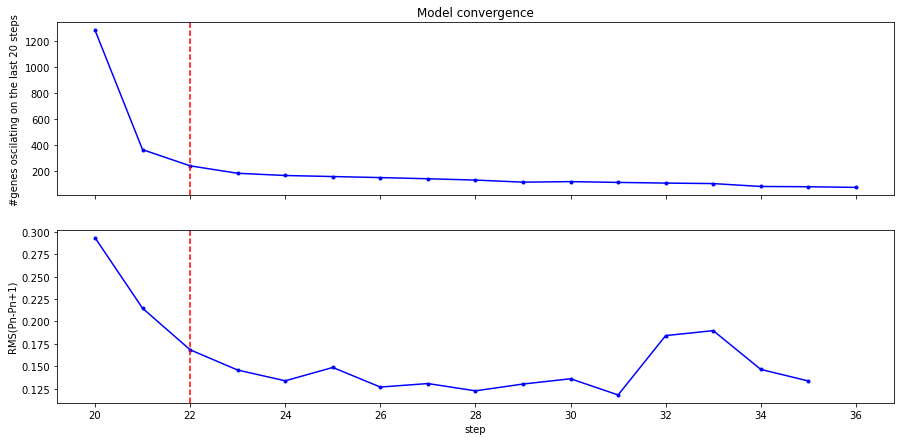

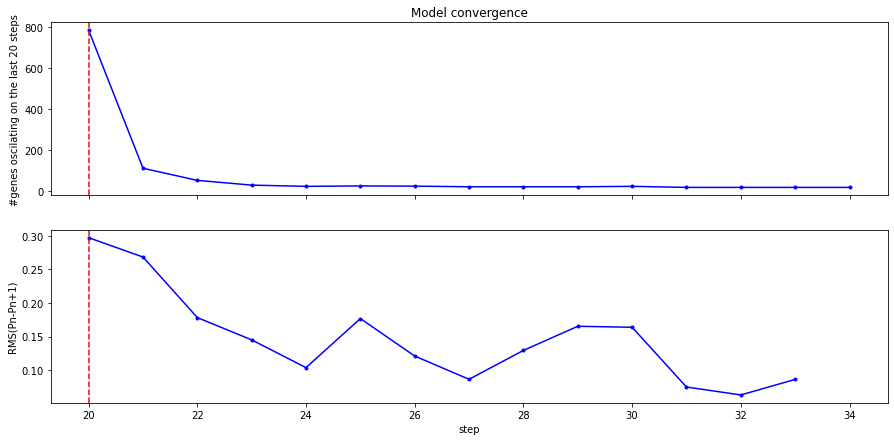

In [8]:
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"

bics = run_DESMOND(exprs_file, out_dir = out_dir,basename = False,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed)

Will save output files to: tmp_results/TCGA-RNAseq_13K.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 54
total samples: 1081, min_n_samples: 54, n_permutations: 100
		genes processed: 0
Gene SIDT1: SNR=1.95, pos=0, neg=185


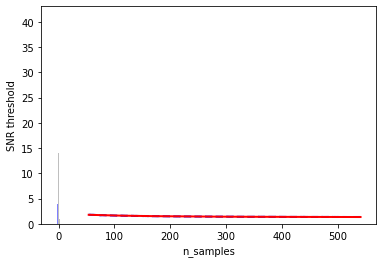

Gene CLIC6: SNR=1.88, pos=364, neg=0


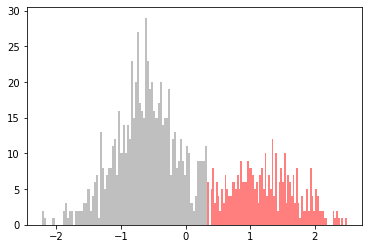

		genes processed: 1000
		genes processed: 2000
Gene ZNHIT2: SNR=3.23, pos=0, neg=65


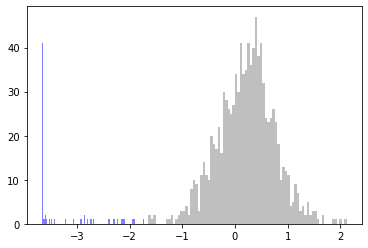

		genes processed: 3000
Gene GRB7: SNR=2.18, pos=91, neg=0


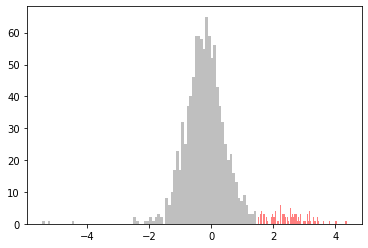

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.23, pos=0, neg=265


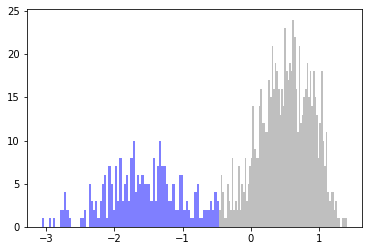

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=-2.32, pos=101, neg=0


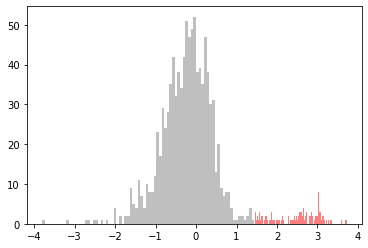

Gene GSTT1: SNR=4.58, pos=0, neg=196


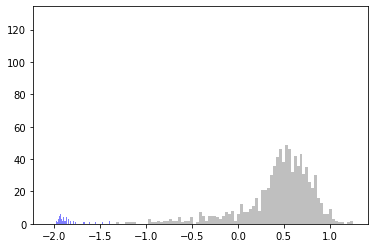

Gene GATA3: SNR=1.61, pos=0, neg=265


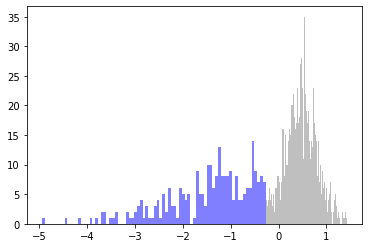

		genes processed: 9000
Gene FOXA1: SNR=2.24, pos=0, neg=200


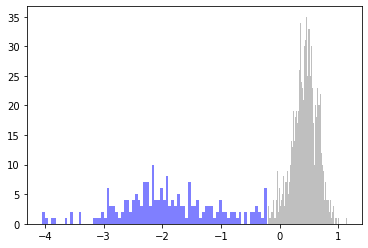

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=1.86, pos=410, neg=0


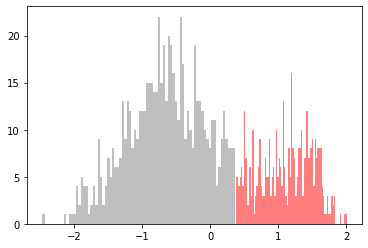

		genes processed: 12000
		genes processed: 13000
Total runtime 154.22 s for  13361 genes
	up-regulated genes: 1574
	down-regulated genes: 1326
	inexplicit genes: 471
Searching for UP-regulated biclusters ...
		KxN=1574x1081
		p0= -749.2921021853009
	 1000 genes processed in  7.6 s
time:	Initial state created in 8.6 s.
		LP matrix memory usage: 18.90M
step 1
1000 		genes processed in 58.5 s runtime...
	step  1 82.5 s
step 2
1000 		genes processed in 7.9 s runtime...
	step  2 14.4 s
step 3
1000 		genes processed in 3.8 s runtime...
	step  3 6.9 s
step 4
1000 		genes processed in 2.0 s runtime...
	step  4 3.0 s
step 5
1000 		genes processed in 1.7 s runtime...
	step  5 2.5 s
step 6
1000 		genes processed in 1.6 s runtime...
	step  6 3.5 s
step 7
1000 		genes processed in 1.8 s runtime...
	step  7 3.2 s
step 8
1000 		genes processed in 1.7 s runtime...
	step  8 2.8 s
step 9
1000 		genes processed in 1.6 s runtime...
	step  9 2.5 s
step 10
1000 		genes processed in 1.6 s runtime...
	step  

time:	Identified optimal sample sets for 1326 modules in 29.12 s.
	Empty modules: 92
	Modules with just 1 edge: 92
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 1
Passed modules with >= 2 genes and >= 54 samples: 464
3x305	0.921	BST2 CFB RARRES3
3x590	1.364	SCGB1D2 SCGB2A1 SCGB2A2
167x221	0.967	ABCC11 ABCC8 ACADSB ACOT4 AFF3 AGR2 AGR3 AKR7A3 ANKRA2 ANKRD30A ANXA9 APPL2 AR ARSG ATP8B1 BBS1 BCAM BCAS1 BCL2 BNIPL BTF3 C1orf21 C1orf64 C4orf32 C5orf30 C9orf116 CA12 CACNA2D2 CACNG4 CAMK2N1 CAPN13 CAPN9 CASC1 CCDC125 CCDC96 CCNH CELSR1 CIRBP CLGN CLSTN2 CMBL CRIP1 CST9 CXXC5 CYB5A DACH1 DAZAP2 DBNDD2 DNAH5 DNAH7 DNAL1 DNALI1 DYNLRB2 EAPP EPB41L4A ERBB4 ERGIC1 ESR1 EXOC6 FAM110C FAM46C FBP1 FOXA1 FSIP1 FSTL4 GAMT GATA3 GLS2 GP2 GPD1L GPRC5C GSTO2 HPN INPP4B IQCH KCNJ11 KCNK15 KIAA0825 KIAA1324 KLHDC1 KRT37 KSR2 LCMT2 LIMA1 LONRF2 LRRC46 LRRC56 LYPD6 MAG MAP3K12 MLPH MMP17 MOAP1 MSX2 MYB MYRIP NBEA NEK9 NOSTRIN NPNT PALM PAX2 PAX9 PCP2 PCSK4 PLA2G4F P

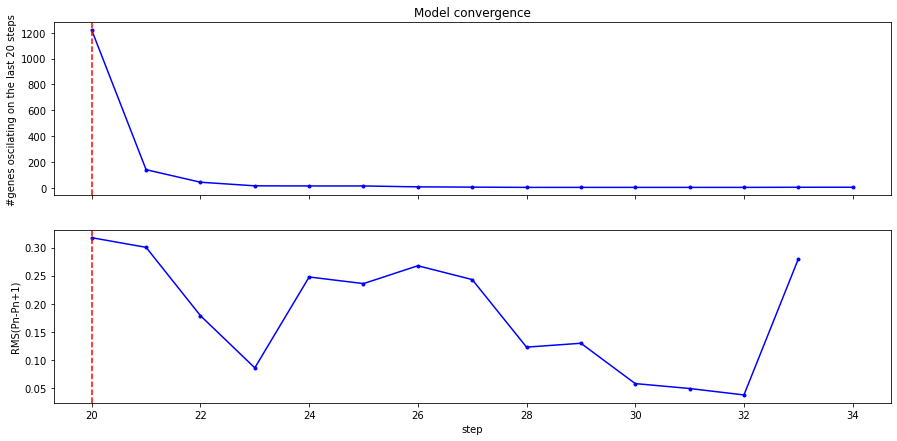

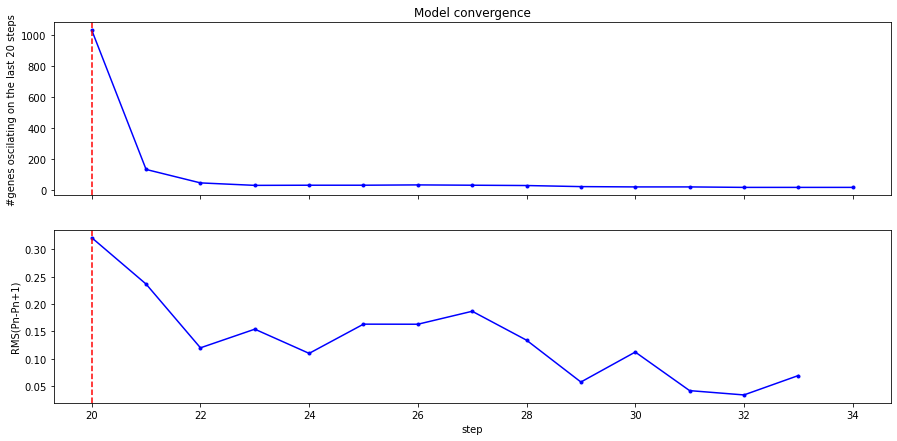

In [10]:
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/TCGA_RNAseq.RSEM.log2.z.13K_common.tsv"
basename= "TCGA-RNAseq_13K"
bics2 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed)

Will save output files to: tmp_results/METABRIC_13K_pv0.005.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 95
total samples: 1904, min_n_samples: 95, n_permutations: 1000


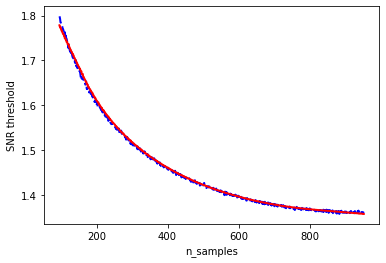

		genes processed: 0
Gene SIDT1: SNR=1.37, pos=0, neg=0


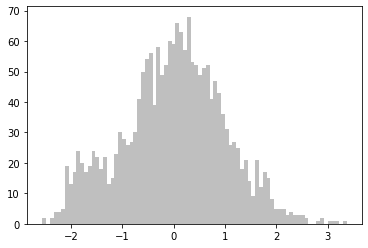

Gene CLIC6: SNR=-1.95, pos=762, neg=0


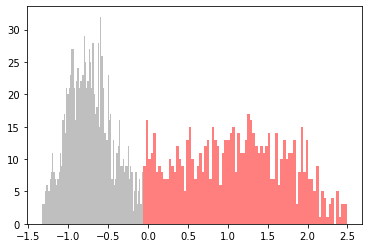

		genes processed: 1000
		genes processed: 2000
Gene HLA-A: SNR=3.75, pos=0, neg=464


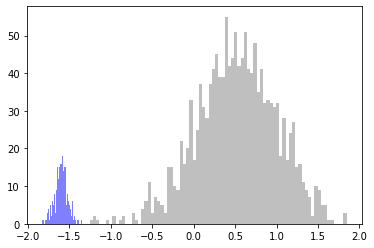

		genes processed: 3000
Gene GRB7: SNR=-2.14, pos=254, neg=0


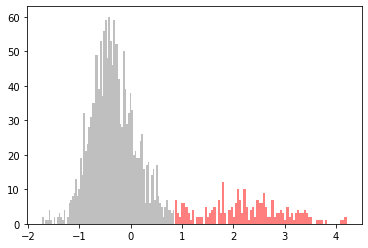

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.64, pos=0, neg=443


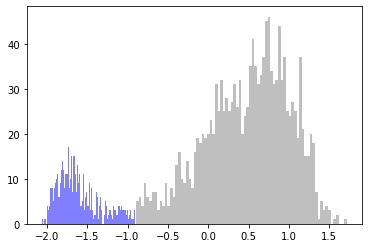

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=2.48, pos=217, neg=0


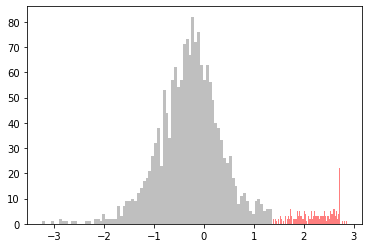

Gene GSTT1: SNR=-3.42, pos=0, neg=355


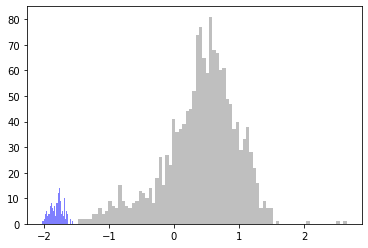

Gene GATA3: SNR=1.9, pos=0, neg=438


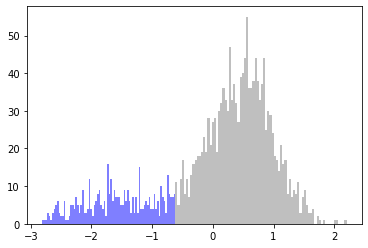

		genes processed: 9000
Gene FOXA1: SNR=2.83, pos=0, neg=254


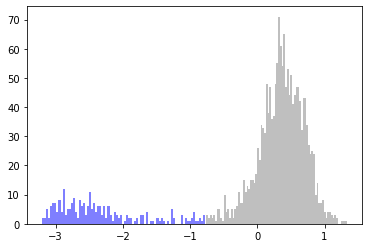

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=2.07, pos=887, neg=1017


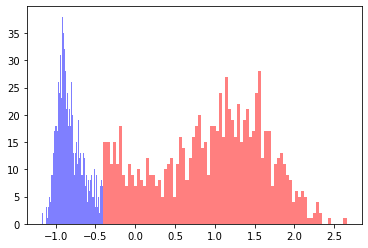

		genes processed: 12000
		genes processed: 13000
Total runtime 307.91 s for  13361 genes
	up-regulated genes: 1043
	down-regulated genes: 473
	inexplicit genes: 210
Searching for UP-regulated biclusters ...
		KxN=1043x1904
		p0= -1319.7522317861358
	 1000 genes processed in  10.9 s
time:	Initial state created in 11.0 s.
		LP matrix memory usage: 8.30M
step 1
1000 		genes processed in 77.0 s runtime...
	step  1 79.5 s
step 2
1000 		genes processed in 10.4 s runtime...
	step  2 11.1 s
step 3
1000 		genes processed in 4.4 s runtime...
	step  3 4.5 s
step 4
1000 		genes processed in 3.7 s runtime...
	step  4 4.2 s
step 5
1000 		genes processed in 2.2 s runtime...
	step  5 2.6 s
step 6
1000 		genes processed in 1.4 s runtime...
	step  6 1.5 s
step 7
1000 		genes processed in 1.1 s runtime...
	step  7 1.3 s
step 8
1000 		genes processed in 1.5 s runtime...
	step  8 1.8 s
step 9
1000 		genes processed in 1.2 s runtime...
	step  9 1.3 s
step 10
1000 		genes processed in 1.2 s runtime...
	step

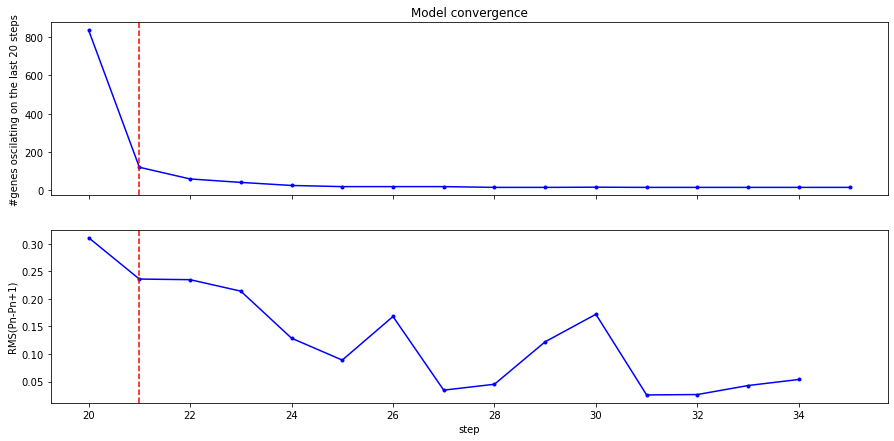

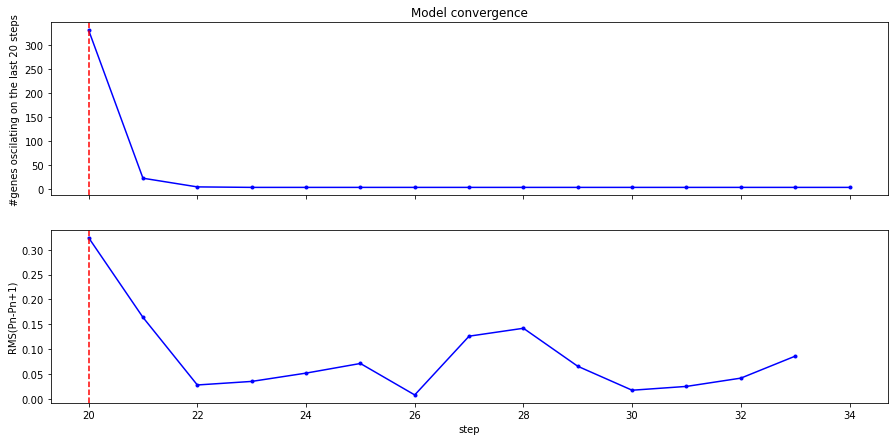

In [5]:
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/METABRIC_micro_nolog2.z.13K_common.tsv"
basename= "METABRIC_13K_pv0.005"
bics3 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed, snr_pval=0.005)

Will save output files to: tmp_results/METABRIC_13K_1000_pv0.005.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 50
total samples: 1000, min_n_samples: 50, n_permutations: 1000


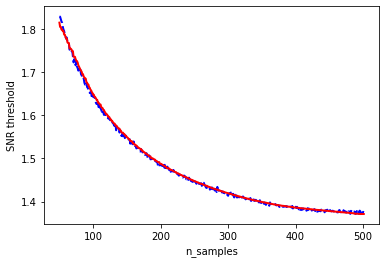

		genes processed: 0
Gene SIDT1: SNR=1.38, pos=0, neg=0


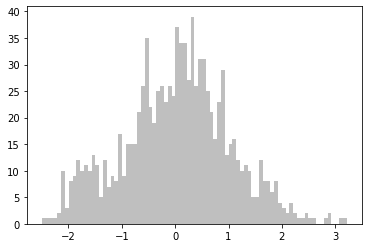

Gene CLIC6: SNR=1.91, pos=426, neg=0


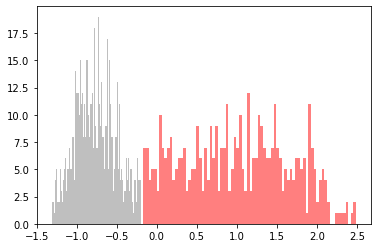

		genes processed: 1000
		genes processed: 2000
Gene HLA-A: SNR=-3.83, pos=0, neg=242


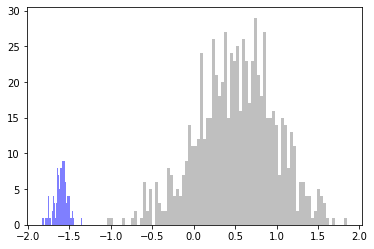

		genes processed: 3000
Gene GRB7: SNR=-2.15, pos=133, neg=0


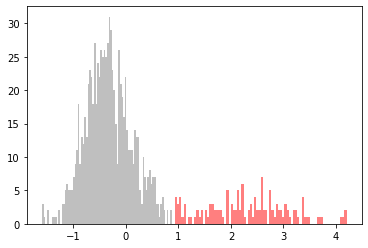

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.6, pos=0, neg=241


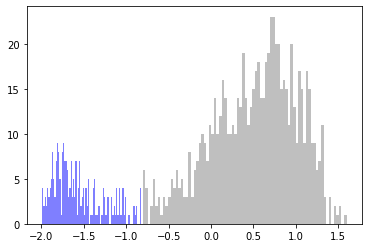

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=-2.56, pos=116, neg=0


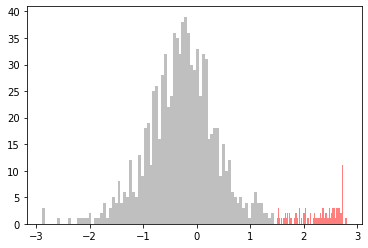

Gene GSTT1: SNR=3.48, pos=0, neg=182


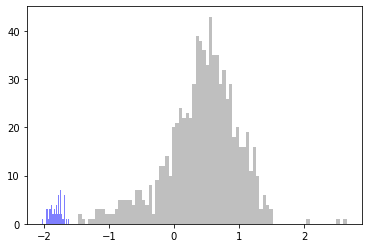

Gene GATA3: SNR=1.79, pos=0, neg=242


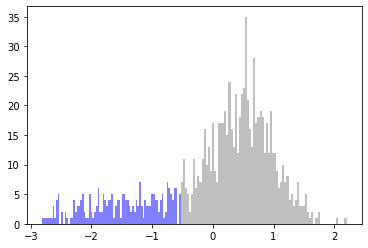

		genes processed: 9000
Gene FOXA1: SNR=2.61, pos=0, neg=128


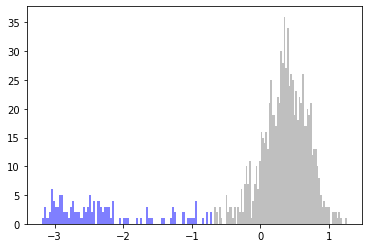

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=-2.23, pos=440, neg=0


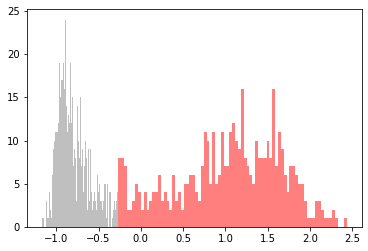

		genes processed: 12000
		genes processed: 13000
Total runtime 162.62 s for  13361 genes
	up-regulated genes: 894
	down-regulated genes: 450
	inexplicit genes: 204
Searching for UP-regulated biclusters ...
		KxN=894x1000
		p0= -693.1471805599452
time:	Initial state created in 2.4 s.
		LP matrix memory usage: 6.10M
step 1
	step  1 23.2 s
step 2
	step  2 5.7 s
step 3
	step  3 3.3 s
step 4
	step  4 1.7 s
step 5
	step  5 1.5 s
step 6
	step  6 1.4 s
step 7
	step  7 1.4 s
step 8
	step  8 1.2 s
step 9
	step  9 1.3 s
step 10
	step  10 1.2 s
step 11
	step  11 1.2 s
step 12
	step  12 1.1 s
step 13
	step  13 0.9 s
step 14
	step  14 1.4 s
step 15
	step  15 1.3 s
step 16
	step  16 1.2 s
step 17
	step  17 1.0 s
step 18
	step  18 1.1 s
step 19
	step  19 1.3 s
step 20
	step  20 1.1 s
step 21
	step  21 1.0 s
step 22
	step  22 1.1 s
step 23
	step  23 1.2 s
step 24
	step  24 1.4 s
step 25
	step  25 1.1 s
step 26
	step  26 1.0 s
step 27
	step  27 1.0 s
step 28
	step  28 0.9 s
step 29
	step  29 1.0 s
step

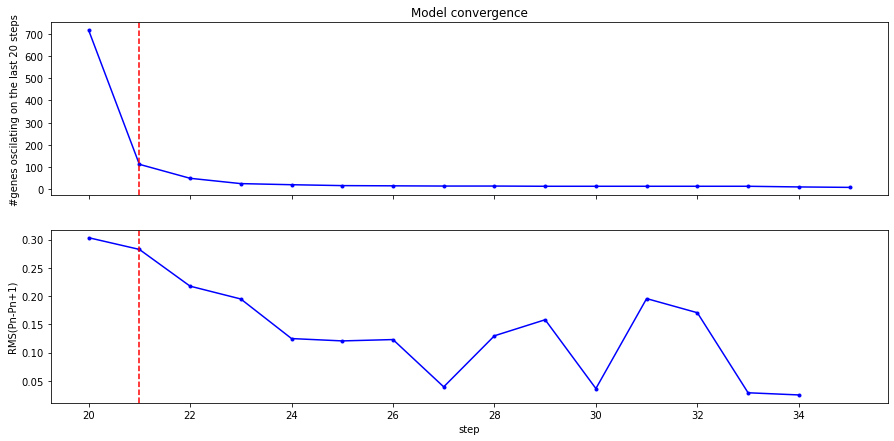

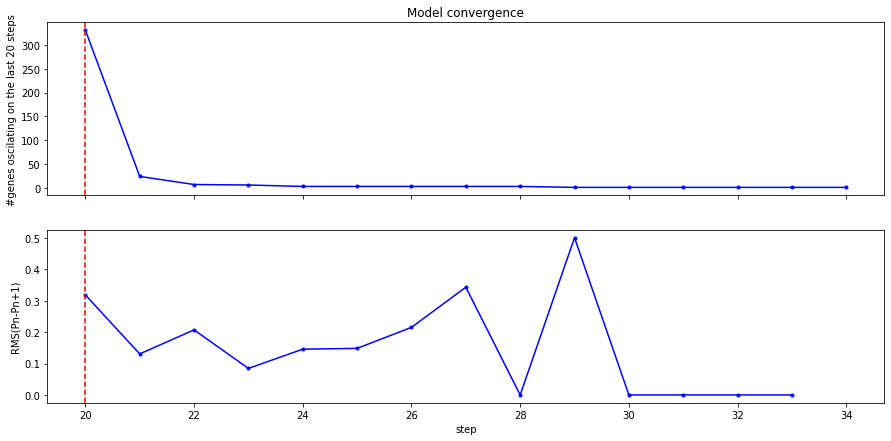

In [6]:
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/METABRIC_micro_nolog2.z.13K_common.downsampled_1000.tsv"
basename= "METABRIC_13K_1000_pv0.005"
bics3 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed, snr_pval=0.005)

Will save output files to: tmp_results/METABRIC_13K_500_pv0.005.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 25
total samples: 500, min_n_samples: 25, n_permutations: 1000


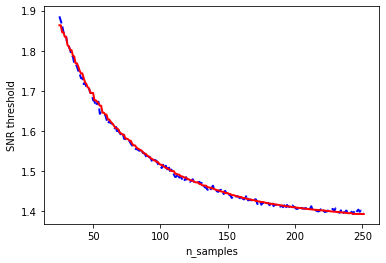

		genes processed: 0
Gene SIDT1: SNR=1.39, pos=0, neg=0


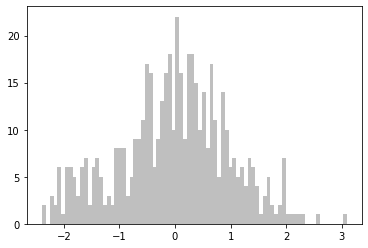

Gene CLIC6: SNR=1.99, pos=204, neg=0


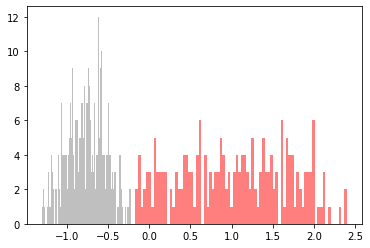

		genes processed: 1000
		genes processed: 2000
Gene HLA-A: SNR=3.72, pos=0, neg=122


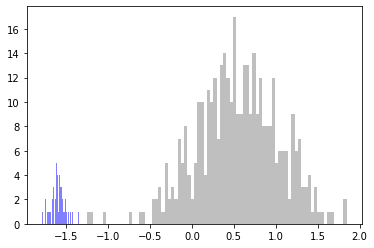

		genes processed: 3000
Gene GRB7: SNR=-2.04, pos=69, neg=0


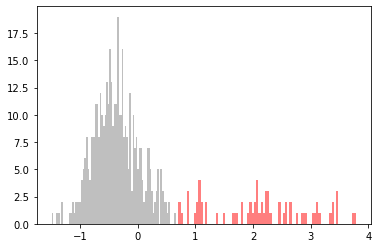

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.72, pos=0, neg=113


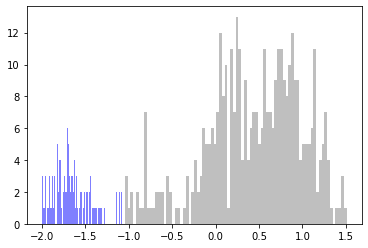

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=-2.38, pos=59, neg=0


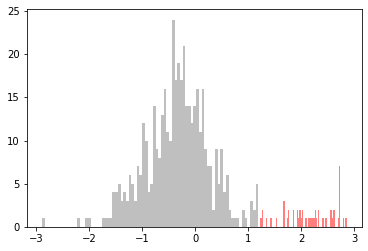

Gene GSTT1: SNR=-3.1, pos=0, neg=101


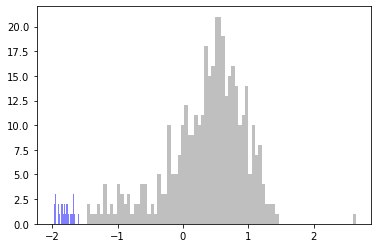

Gene GATA3: SNR=2.02, pos=0, neg=113


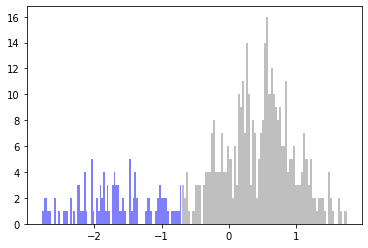

		genes processed: 9000
Gene FOXA1: SNR=3.57, pos=0, neg=71


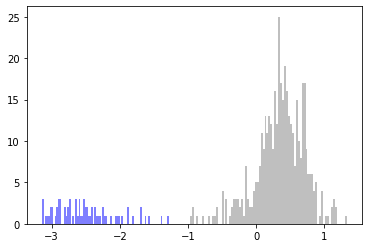

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=-1.82, pos=269, neg=231


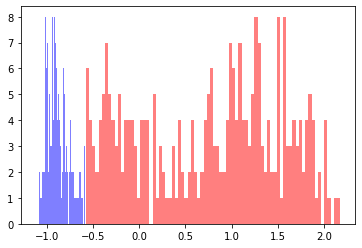

		genes processed: 12000
		genes processed: 13000
Total runtime 113.22 s for  13361 genes
	up-regulated genes: 985
	down-regulated genes: 503
	inexplicit genes: 227
Searching for UP-regulated biclusters ...
		KxN=985x500
		p0= -346.5735902799726
time:	Initial state created in 2.3 s.
		LP matrix memory usage: 7.40M
step 1
	step  1 14.2 s
step 2
	step  2 4.2 s
step 3
	step  3 2.8 s
step 4
	step  4 3.4 s
step 5
	step  5 2.6 s
step 6
	step  6 2.4 s
step 7
	step  7 2.3 s
step 8
	step  8 2.6 s
step 9
	step  9 2.3 s
step 10
	step  10 1.6 s
step 11
	step  11 1.4 s
step 12
	step  12 1.4 s
step 13
	step  13 2.0 s
step 14
	step  14 1.6 s
step 15
	step  15 2.4 s
step 16
	step  16 1.4 s
step 17
	step  17 1.5 s
step 18
	step  18 1.5 s
step 19
	step  19 1.3 s
step 20
	step  20 1.7 s
step 21
	step  21 1.5 s
step 22
	step  22 1.5 s
step 23
	step  23 1.4 s
step 24
	step  24 1.5 s
step 25
	step  25 1.7 s
step 26
	step  26 1.6 s
step 27
	step  27 1.5 s
step 28
	step  28 1.6 s
step 29
	step  29 1.5 s
step 

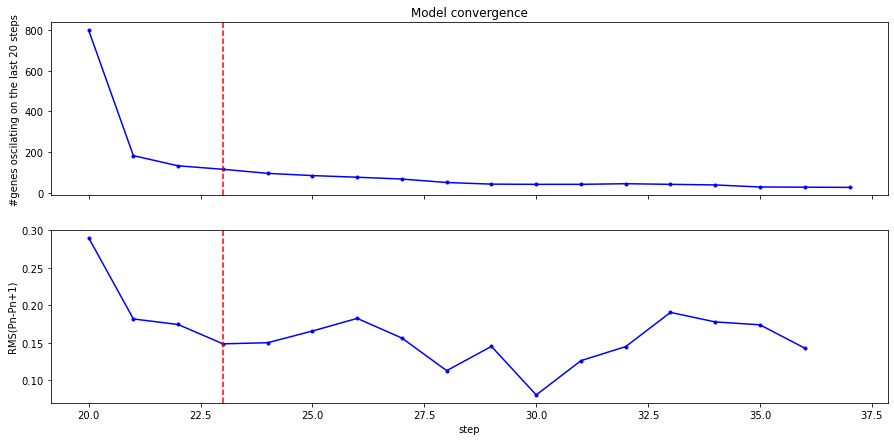

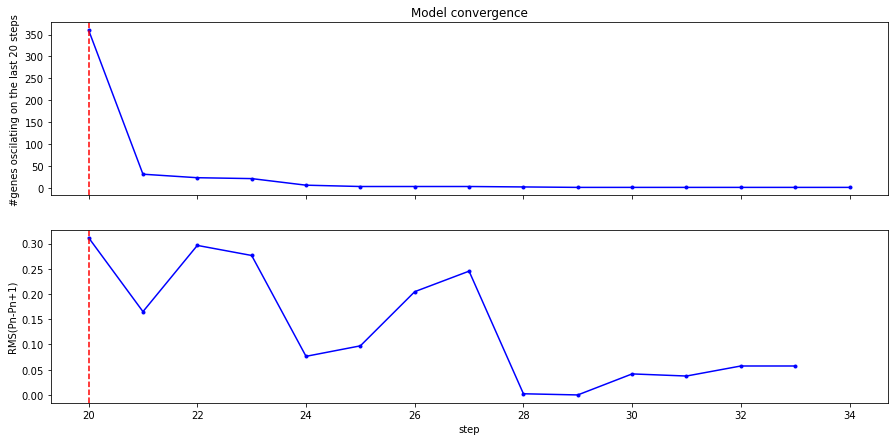

In [4]:
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/METABRIC_micro_nolog2.z.13K_common.downsampled_500.tsv"
basename= "METABRIC_13K_500_pv0.005"
bics3 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed, snr_pval=0.005)

Will save output files to: tmp_results/METABRIC_TNBC_24K.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 14
total samples: 299, min_n_samples: 14, n_permutations: 334


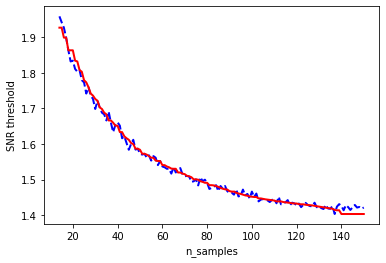

		genes processed: 0
		genes processed: 1000
		genes processed: 2000
Gene FOXA1: SNR=2.48, pos=96, neg=0


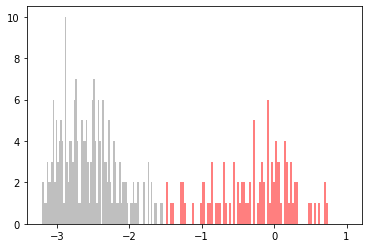

		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene BMPR1B: SNR=-1.33, pos=0, neg=0


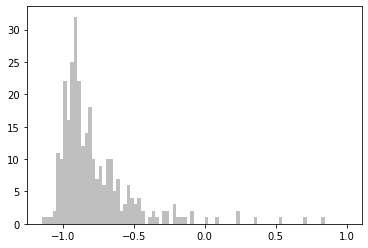

		genes processed: 9000
		genes processed: 10000
Gene ESR1: SNR=1.63, pos=75, neg=0


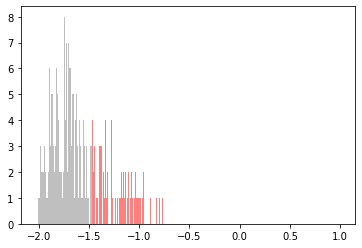

		genes processed: 11000
		genes processed: 12000
Gene CLIC6: SNR=-1.7, pos=0, neg=0


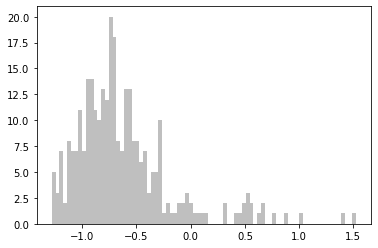

Gene ERBB2: SNR=1.18, pos=0, neg=0


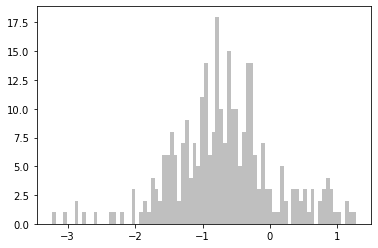

		genes processed: 13000
		genes processed: 14000
		genes processed: 15000
		genes processed: 16000
Gene HLA-A: SNR=4.09, pos=0, neg=72


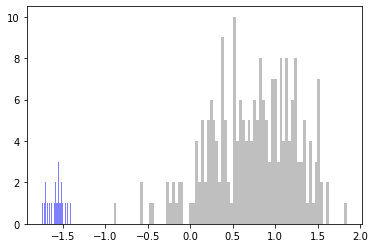

		genes processed: 17000
		genes processed: 18000
Gene GRB7: SNR=1.49, pos=0, neg=0


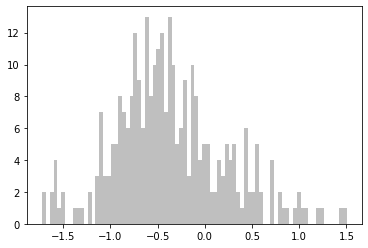

Gene GATA3: SNR=1.46, pos=0, neg=0


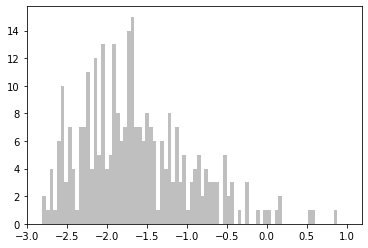

		genes processed: 19000
		genes processed: 20000
Gene HLA-DRB1: SNR=4.37, pos=87, neg=0


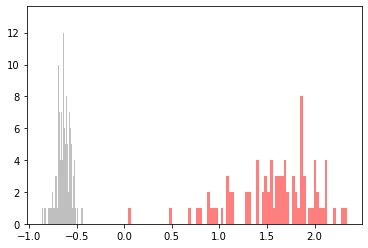

		genes processed: 21000
		genes processed: 22000
Gene SIDT1: SNR=1.6, pos=99, neg=0


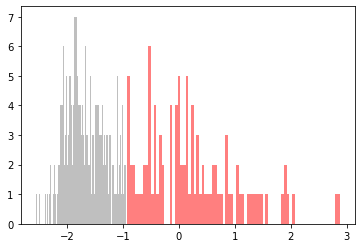

		genes processed: 23000
		genes processed: 24000
Total runtime 208.29 s for  24360 genes
	up-regulated genes: 1396
	down-regulated genes: 643
	inexplicit genes: 366
Searching for UP-regulated biclusters ...
		KxN=1396x299
		p0= -207.25100698742364
	 1000 genes processed in  3.9 s
time:	Initial state created in 4.2 s.
		LP matrix memory usage: 14.87M
step 1
1000 		genes processed in 21.1 s runtime...
	step  1 26.6 s
step 2
1000 		genes processed in 6.1 s runtime...
	step  2 9.5 s
step 3
1000 		genes processed in 3.0 s runtime...
	step  3 4.9 s
step 4
1000 		genes processed in 2.3 s runtime...
	step  4 4.2 s
step 5
1000 		genes processed in 3.1 s runtime...
	step  5 4.9 s
step 6
1000 		genes processed in 2.5 s runtime...
	step  6 4.0 s
step 7
1000 		genes processed in 2.0 s runtime...
	step  7 3.7 s
step 8
1000 		genes processed in 2.3 s runtime...
	step  8 4.1 s
step 9
1000 		genes processed in 2.0 s runtime...
	step  9 4.0 s
step 10
1000 		genes processed in 2.2 s runtime...
	step  10

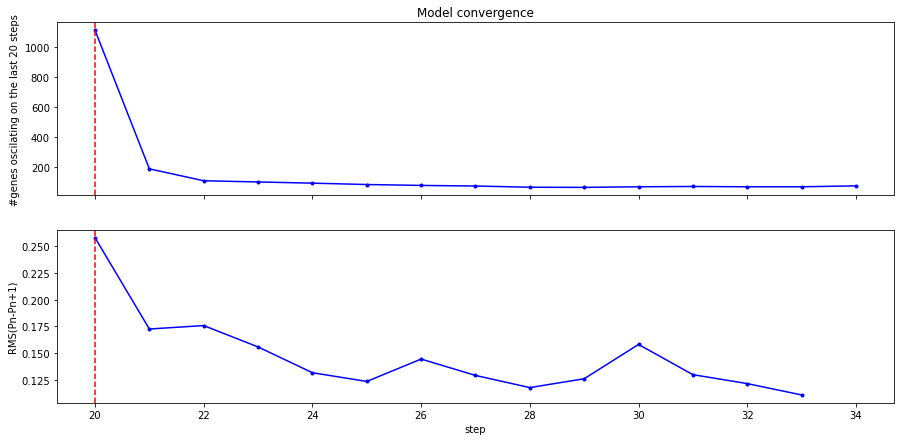

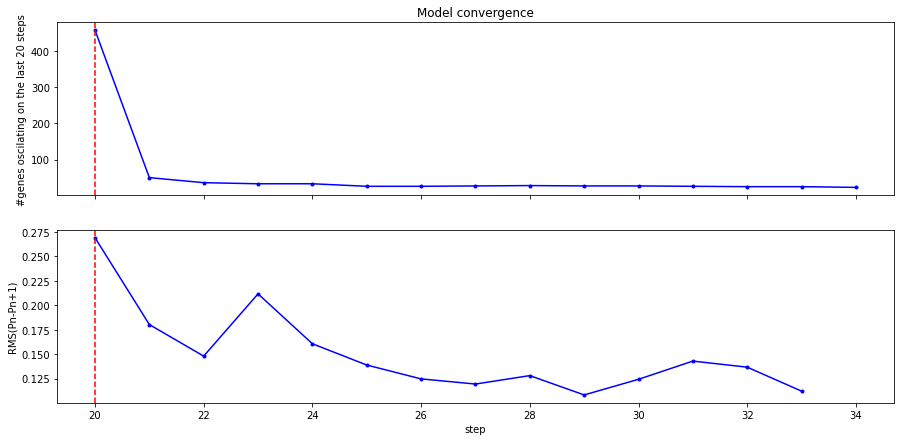

In [9]:
exprs_file = "../datasets/METABRIC_299TNBC.nolog2_exprs_z.tsv"
basename= "METABRIC_TNBC_24K"
bics5 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed)

Will save output files to: tmp_results/METABRIC_24K_pv0.005.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 95
total samples: 1904, min_n_samples: 95, n_permutations: 1000


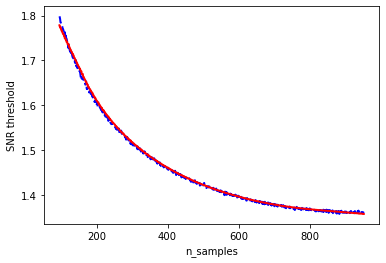

		genes processed: 0
		genes processed: 1000
		genes processed: 2000
Gene FOXA1: SNR=2.83, pos=0, neg=254


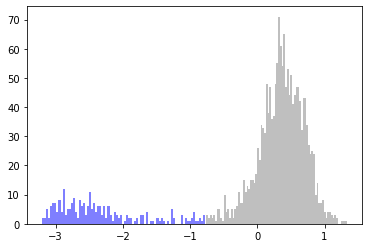

		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene BMPR1B: SNR=2.07, pos=887, neg=1017


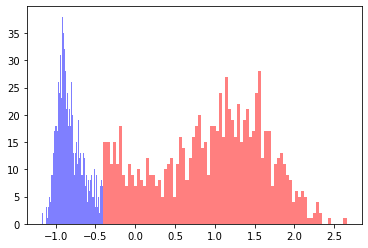

		genes processed: 9000
		genes processed: 10000
Gene ESR1: SNR=2.64, pos=0, neg=443


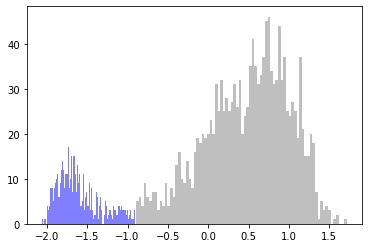

		genes processed: 11000
		genes processed: 12000
Gene CLIC6: SNR=-1.95, pos=762, neg=0


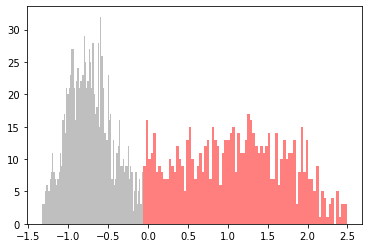

Gene ERBB2: SNR=2.48, pos=217, neg=0


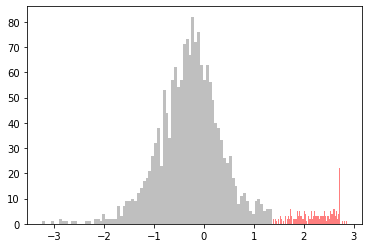

		genes processed: 13000
		genes processed: 14000
		genes processed: 15000
		genes processed: 16000
Gene HLA-A: SNR=3.75, pos=0, neg=464


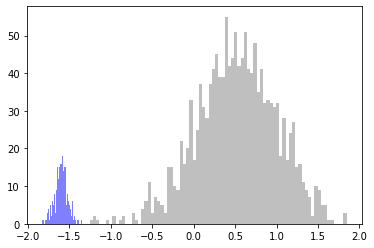

		genes processed: 17000
		genes processed: 18000
Gene GRB7: SNR=-2.14, pos=254, neg=0


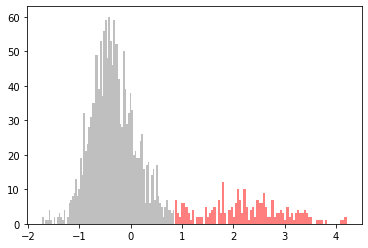

Gene GATA3: SNR=1.9, pos=0, neg=438


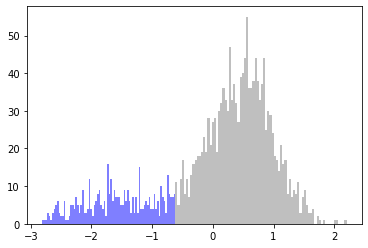

		genes processed: 19000
		genes processed: 20000
Gene HLA-DRB1: SNR=4.63, pos=573, neg=0


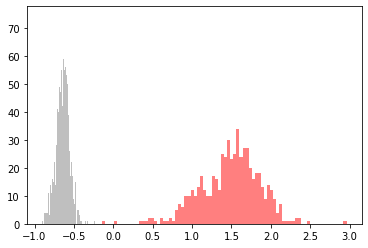

		genes processed: 21000
		genes processed: 22000
Gene SIDT1: SNR=1.37, pos=0, neg=0


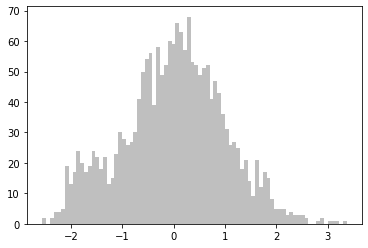

		genes processed: 23000
Gene GSTT1: SNR=-3.42, pos=0, neg=355


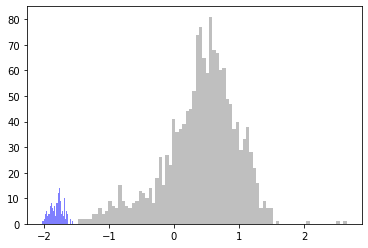

		genes processed: 24000
Total runtime 503.84 s for  24360 genes
	up-regulated genes: 1348
	down-regulated genes: 584
	inexplicit genes: 268
Searching for UP-regulated biclusters ...
		KxN=1348x1904
		p0= -1319.7522317861358
	 1000 genes processed in  11.0 s
time:	Initial state created in 11.9 s.
		LP matrix memory usage: 13.86M
step 1
1000 		genes processed in 66.7 s runtime...
	step  1 84.0 s
step 2
1000 		genes processed in 12.7 s runtime...
	step  2 19.6 s
step 3
1000 		genes processed in 5.5 s runtime...
	step  3 7.9 s
step 4
1000 		genes processed in 2.3 s runtime...
	step  4 4.3 s
step 5
1000 		genes processed in 1.7 s runtime...
	step  5 2.6 s
step 6
1000 		genes processed in 1.5 s runtime...
	step  6 2.2 s
step 7
1000 		genes processed in 1.6 s runtime...
	step  7 2.5 s
step 8
1000 		genes processed in 1.5 s runtime...
	step  8 2.2 s
step 9
1000 		genes processed in 1.6 s runtime...
	step  9 2.2 s
step 10
1000 		genes processed in 1.6 s runtime...
	step  10 2.4 s
step 11
1000 

Runtime for DOWN-regulated biclusters: 60.62
Total runtime: 1030.73


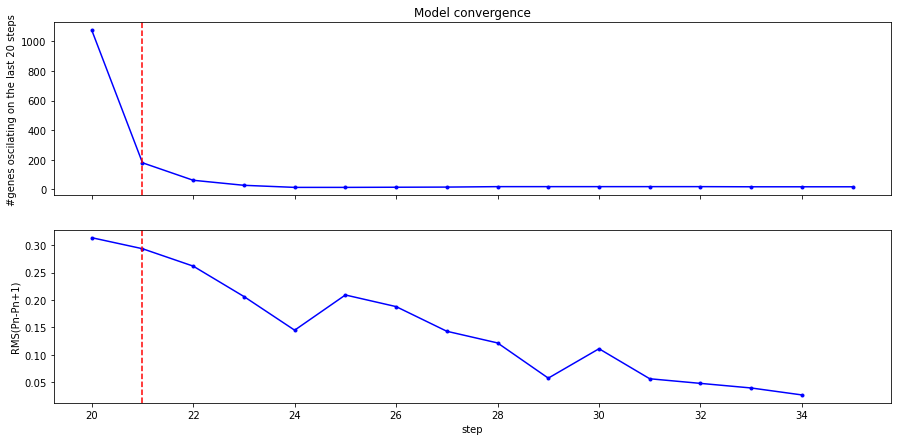

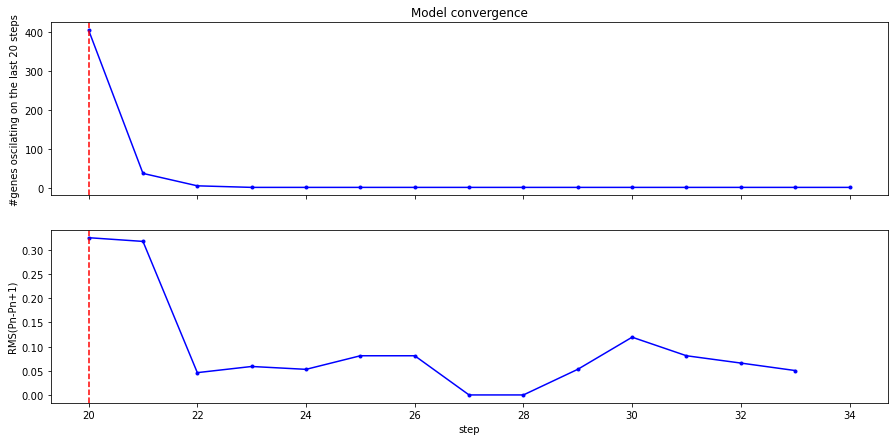

In [7]:
exprs_file = "../datasets/METABRIC_1904.nolog2_exprs_z.tsv"
basename= "METABRIC_24K_pv0.005"
bics6 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed, snr_pval=0.005)

Will save output files to: tmp_results/METABRIC_24K_0.05.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 95
total samples: 1904, min_n_samples: 95, n_permutations: 100


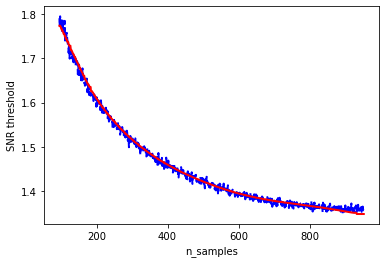

		genes processed: 0
		genes processed: 1000
		genes processed: 2000
Gene FOXA1: SNR=2.83, pos=0, neg=254


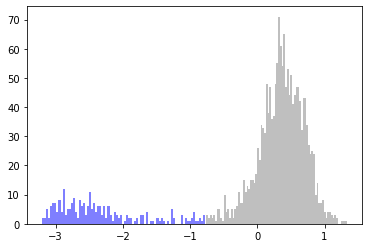

		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene BMPR1B: SNR=2.07, pos=887, neg=1017


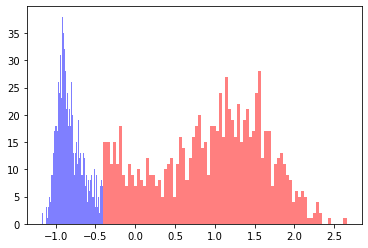

		genes processed: 9000
		genes processed: 10000
Gene ESR1: SNR=2.64, pos=0, neg=443


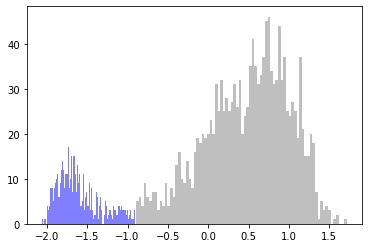

		genes processed: 11000
		genes processed: 12000
Gene CLIC6: SNR=-1.95, pos=762, neg=0


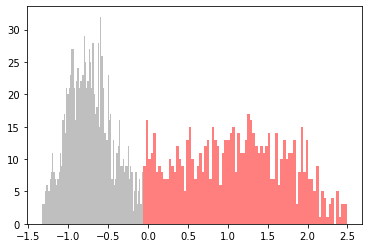

Gene ERBB2: SNR=2.48, pos=217, neg=0


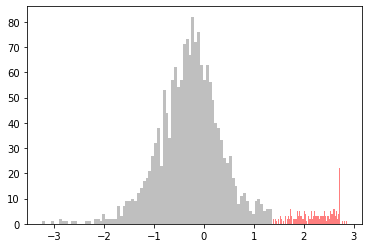

		genes processed: 13000
		genes processed: 14000
		genes processed: 15000
		genes processed: 16000
Gene HLA-A: SNR=3.75, pos=0, neg=464


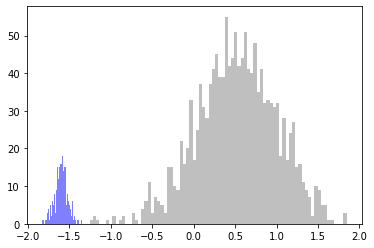

		genes processed: 17000
		genes processed: 18000
Gene GRB7: SNR=-2.14, pos=254, neg=0


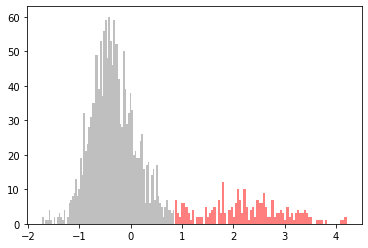

Gene GATA3: SNR=1.9, pos=0, neg=438


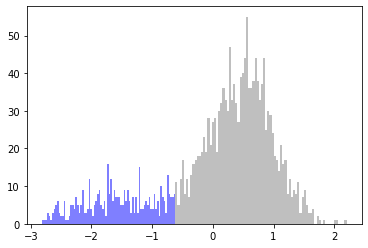

		genes processed: 19000
		genes processed: 20000
Gene HLA-DRB1: SNR=4.63, pos=573, neg=0


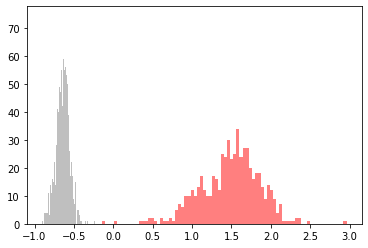

		genes processed: 21000
		genes processed: 22000
Gene SIDT1: SNR=1.37, pos=0, neg=0


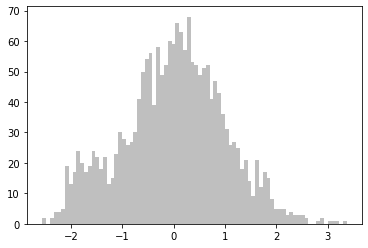

		genes processed: 23000
Gene GSTT1: SNR=-3.42, pos=0, neg=355


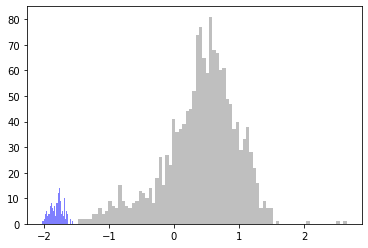

		genes processed: 24000
Total runtime 604.03 s for  24360 genes
	up-regulated genes: 1411
	down-regulated genes: 635
	inexplicit genes: 316
Searching for UP-regulated biclusters ...
		KxN=1411x1904
		p0= -1319.7522317861358
	 1000 genes processed in  7.2 s
time:	Initial state created in 7.7 s.
		LP matrix memory usage: 15.19M
step 1
1000 		genes processed in 67.3 s runtime...
	step  1 88.4 s
step 2
1000 		genes processed in 11.2 s runtime...
	step  2 15.7 s
step 3
1000 		genes processed in 3.0 s runtime...
	step  3 4.6 s
step 4
1000 		genes processed in 1.6 s runtime...
	step  4 2.3 s
step 5
1000 		genes processed in 1.6 s runtime...
	step  5 2.1 s
step 6
1000 		genes processed in 1.6 s runtime...
	step  6 2.4 s
step 7
1000 		genes processed in 1.5 s runtime...
	step  7 2.1 s
step 8
1000 		genes processed in 1.5 s runtime...
	step  8 2.1 s
step 9
1000 		genes processed in 1.5 s runtime...
	step  9 2.1 s
step 10
1000 		genes processed in 1.5 s runtime...
	step  10 2.2 s
step 11
1000 		

Runtime for DOWN-regulated biclusters: 66.18
Total runtime: 960.3


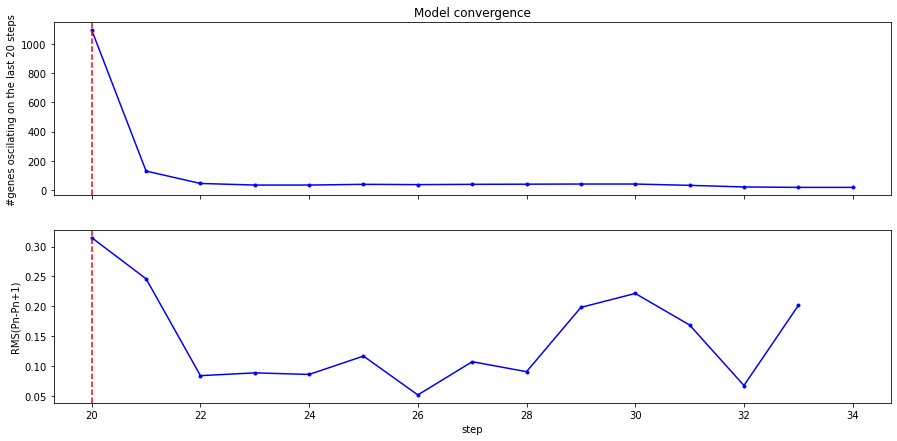

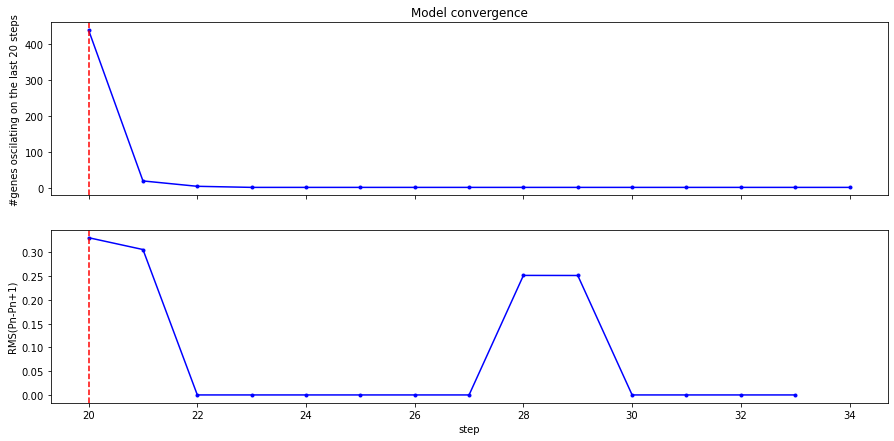

In [9]:
exprs_file = "../datasets/METABRIC_1904.nolog2_exprs_z.tsv"
basename= "METABRIC_24K_0.05"
bics8 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed, snr_pval=0.05)

Will save output files to: tmp_results/TCGA-RNAseq_24K+0.005.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 47
total samples: 945, min_n_samples: 47, n_permutations: 1000


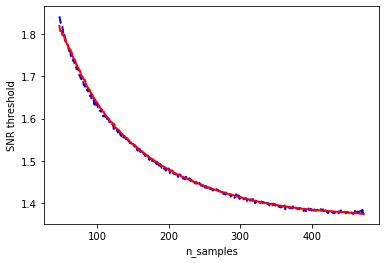

		genes processed: 0
Gene SIDT1: SNR=1.92, pos=0, neg=159


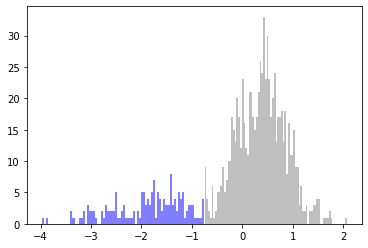

Gene RP5-1172N10.4: SNR=-3.28, pos=86, neg=0


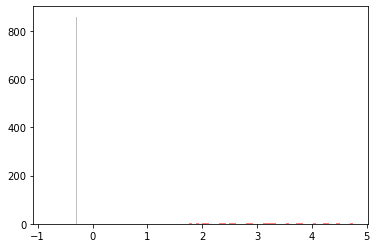

Gene GS1-114I9.3: SNR=-3.19, pos=0, neg=190


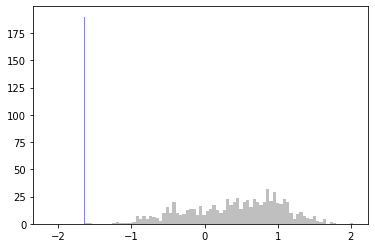

Gene CH17-478G19.2: SNR=3.16, pos=452, neg=493


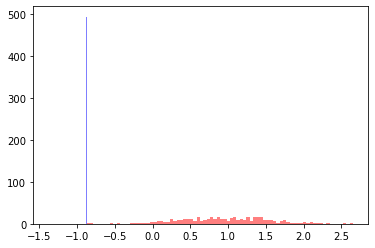

Gene CTD-2545G14.7: SNR=-4.54, pos=62, neg=0


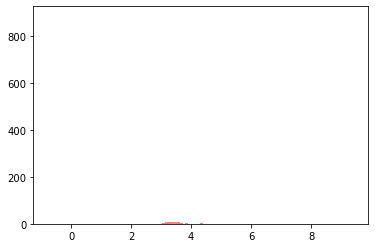

		genes processed: 1000
Gene BIVM-ERCC5: SNR=5.21, pos=0, neg=141


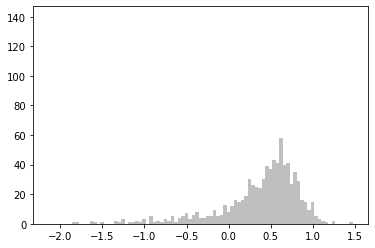

Gene PTCHD3P1: SNR=-3.35, pos=0, neg=165


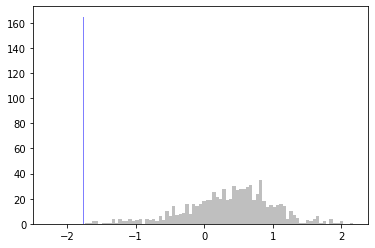

Gene PGBD3: SNR=4.21, pos=0, neg=137


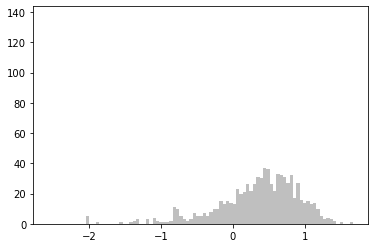

Gene CTD-3126B10.5: SNR=3.31, pos=0, neg=325


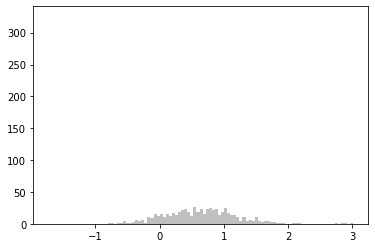

Gene RP11-294J22.6: SNR=-3.68, pos=426, neg=519


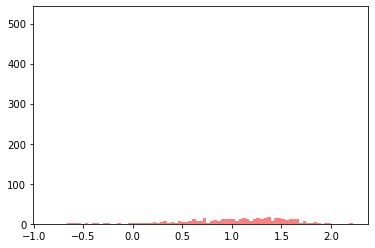

Gene AC008074.1: SNR=-4.36, pos=0, neg=102


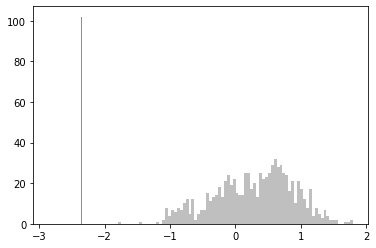

Gene RP11-293I14.2: SNR=3.17, pos=0, neg=296


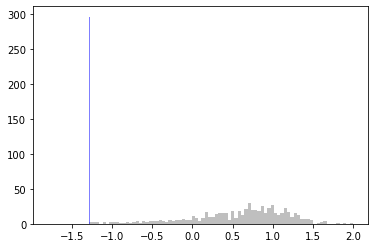

		genes processed: 2000
Gene RP11-514P8.6: SNR=-3.27, pos=0, neg=404


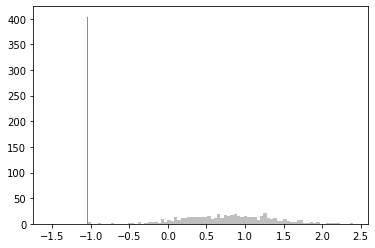

Gene SIGLEC14: SNR=4.92, pos=0, neg=55


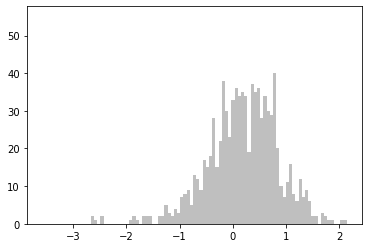

Gene ZBTB45P2: SNR=4.8, pos=0, neg=113


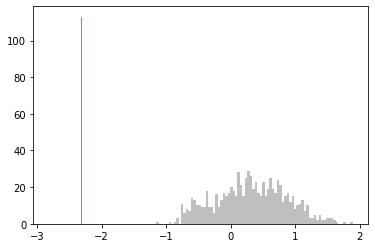

		genes processed: 3000
Gene TRIM6-TRIM34: SNR=-4.07, pos=151, neg=0


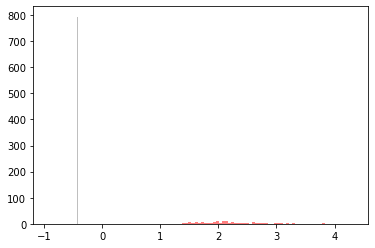

Gene INTS4P1: SNR=3.22, pos=0, neg=88


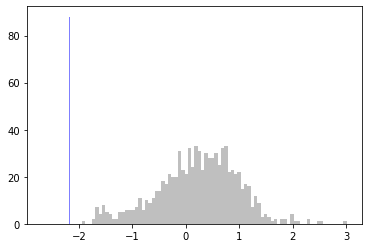

Gene RP11-571M6.7: SNR=-3.11, pos=140, neg=0


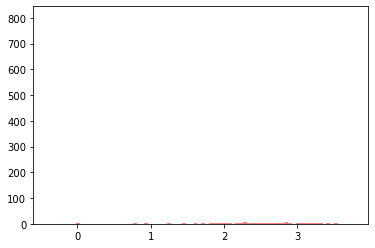

Gene AC002310.11: SNR=3.32, pos=0, neg=200


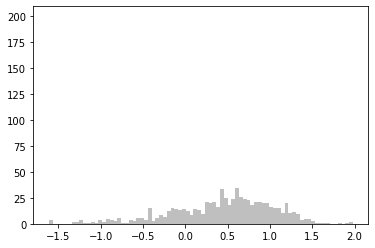

Gene RP11-24N18.1: SNR=3.59, pos=0, neg=116


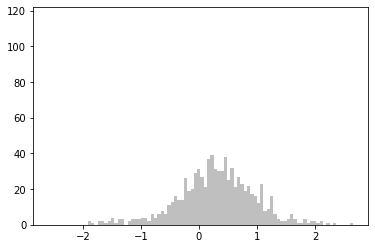

Gene FERP1: SNR=-3.05, pos=0, neg=119


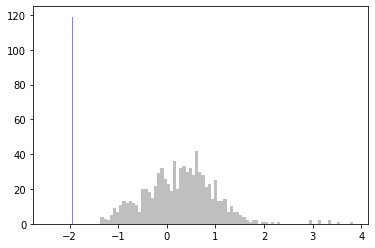

		genes processed: 4000
Gene RP11-500M8.7: SNR=4.01, pos=0, neg=162


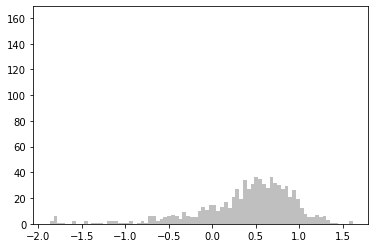

Gene TMBIM4: SNR=3.25, pos=0, neg=383


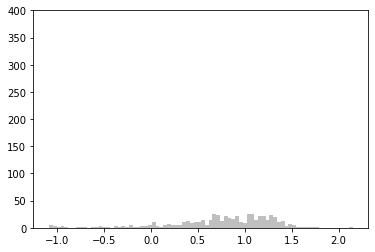

Gene CH17-258A22.4: SNR=4.77, pos=0, neg=65


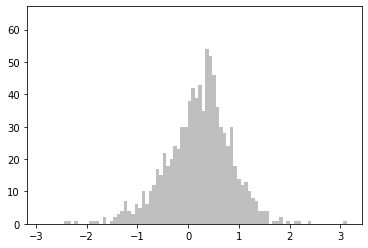

Gene RSC1A1: SNR=4.22, pos=399, neg=0


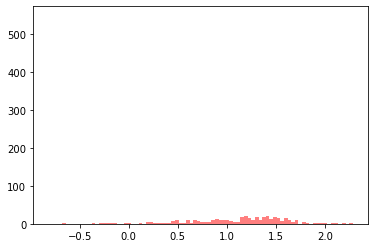

Gene AC009950.1: SNR=4.15, pos=0, neg=205


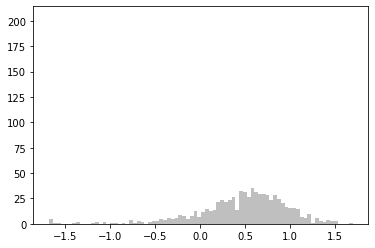

Gene AC006116.27: SNR=3.82, pos=0, neg=104


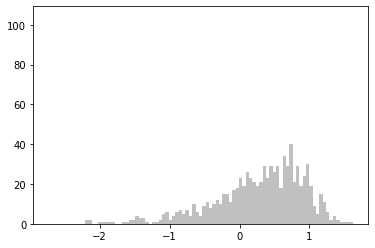

Gene PYCARD-AS1: SNR=3.57, pos=0, neg=212


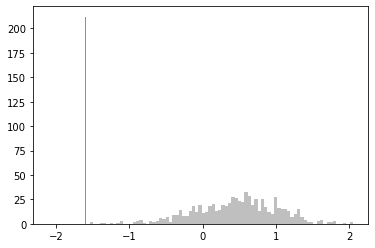

Gene C21orf140: SNR=-6.15, pos=75, neg=0


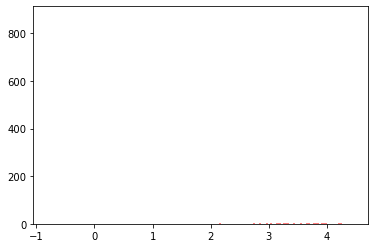

Gene RP11-649E7.5: SNR=7.85, pos=0, neg=77


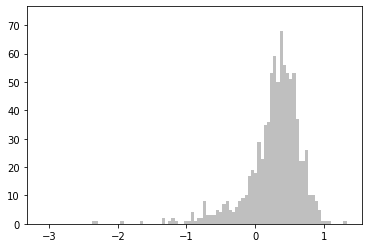

		genes processed: 5000
Gene AF127577.10: SNR=4.41, pos=0, neg=94


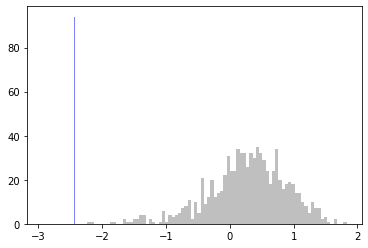

Gene RP11-848G14.2: SNR=3.31, pos=0, neg=81


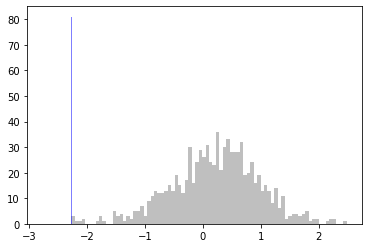

Gene FAM133DP: SNR=-3.3, pos=0, neg=135


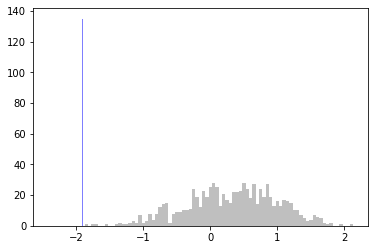

Gene RP11-542C16.2: SNR=3.22, pos=0, neg=377


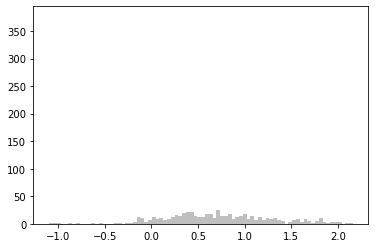

		genes processed: 6000
Gene TMLHE-AS1: SNR=3.25, pos=0, neg=154


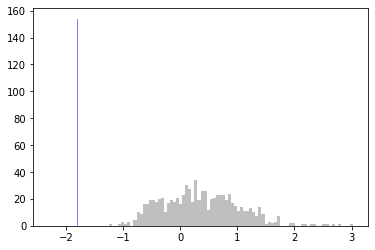

Gene MTND1P23: SNR=-3.36, pos=92, neg=0


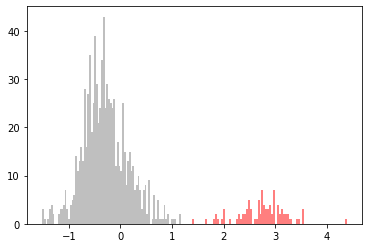

Gene INE2: SNR=3.58, pos=0, neg=104


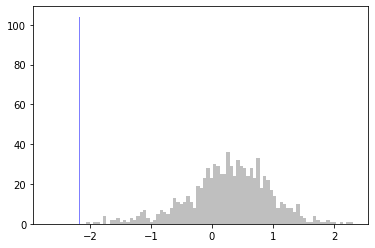

Gene FAM157B: SNR=3.15, pos=0, neg=123


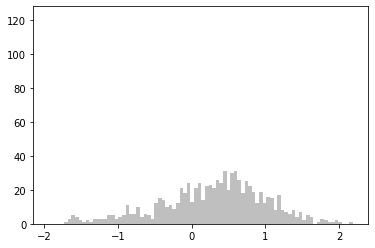

Gene CLIC6: SNR=-1.92, pos=299, neg=0


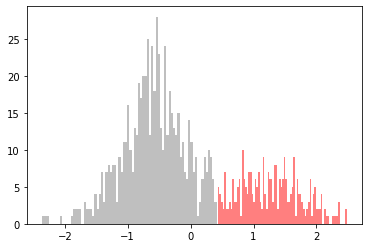

Gene SPDYE10P: SNR=3.89, pos=0, neg=86


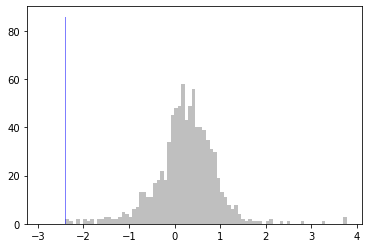

Gene PPAN-P2RY11: SNR=-3.32, pos=0, neg=226


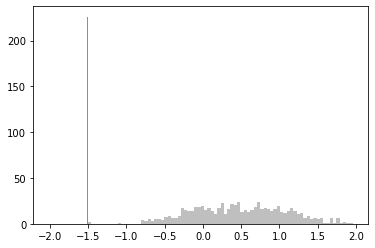

Gene RP1-101K10.6: SNR=-3.21, pos=0, neg=248


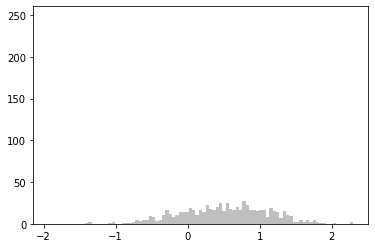

Gene TMEM189-UBE2V1: SNR=-3.89, pos=0, neg=202


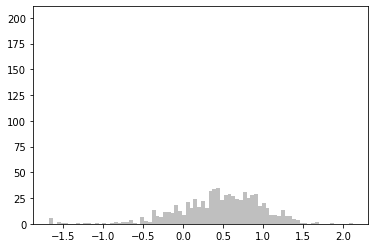

Gene ZACN: SNR=3.03, pos=0, neg=131


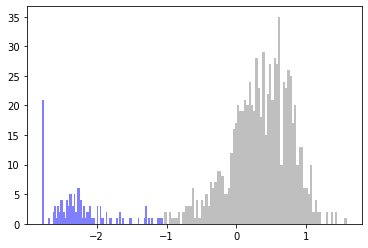

Gene DYX1C1-CCPG1: SNR=3.31, pos=0, neg=322


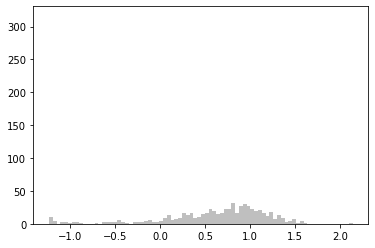

		genes processed: 7000
Gene RP11-1415C14.4: SNR=3.31, pos=0, neg=107


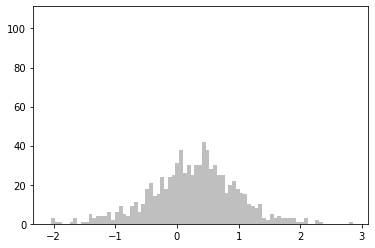

Gene URGCP-MRPS24: SNR=-3.44, pos=0, neg=292


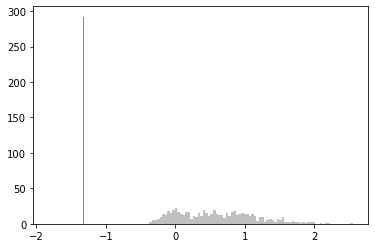

Gene CH17-264B6.3: SNR=3.85, pos=0, neg=142


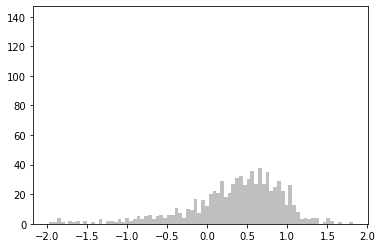

Gene CH17-264B6.4: SNR=-5.64, pos=400, neg=0


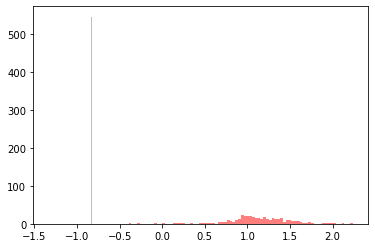

Gene ARAP1-AS1: SNR=3.01, pos=0, neg=219


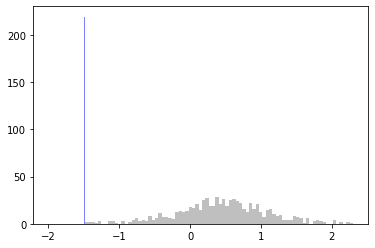

		genes processed: 8000
Gene RP11-1228E12.2: SNR=3.39, pos=0, neg=171


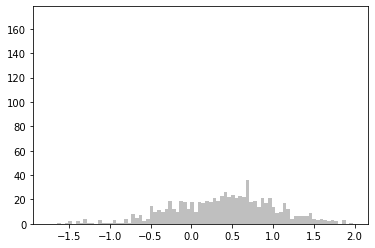

Gene CTD-2196E14.7: SNR=4.33, pos=0, neg=169


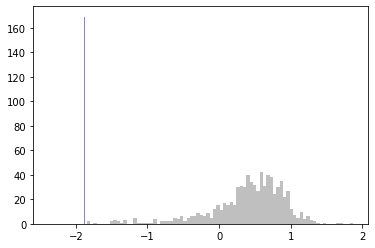

Gene PIK3R2: SNR=-5.18, pos=487, neg=458


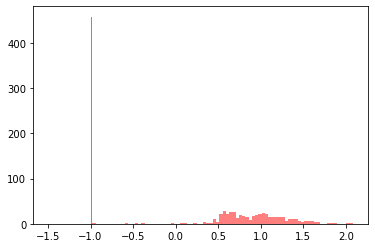

		genes processed: 9000
Gene RP11-56G10.2: SNR=3.32, pos=0, neg=295


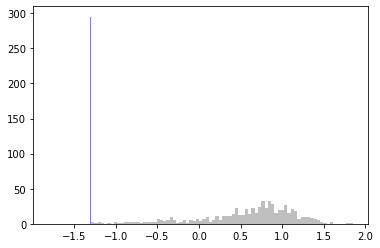

Gene PSMA1: SNR=3.6, pos=0, neg=154


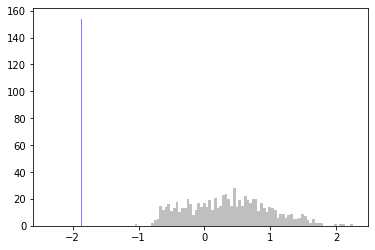

Gene RP11-2B6.2: SNR=3.24, pos=0, neg=115


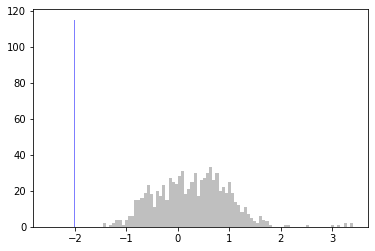

Gene RP11-417N10.4: SNR=3.65, pos=0, neg=98


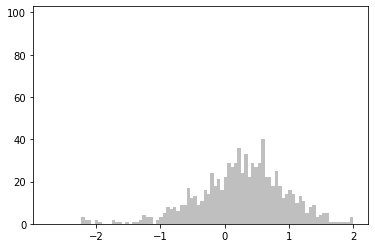

Gene SENP3-EIF4A1: SNR=3.38, pos=0, neg=266


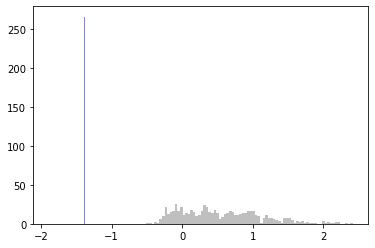

Gene RP11-49K24.6: SNR=4.51, pos=0, neg=187


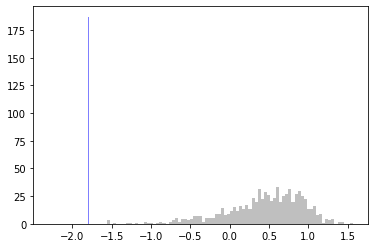

Gene CTD-2036P10.3: SNR=3.21, pos=0, neg=137


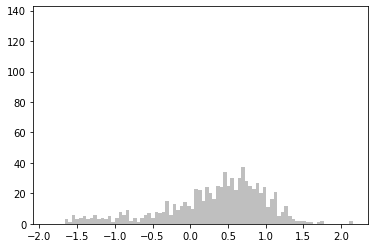

Gene RP11-468E2.2: SNR=4.56, pos=0, neg=103


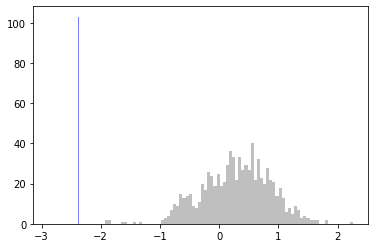

		genes processed: 10000
Gene RP11-361L15.3: SNR=3.27, pos=0, neg=79


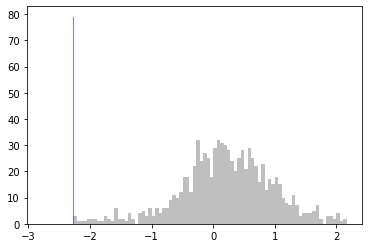

Gene RP11-173P15.5: SNR=-3.34, pos=0, neg=177


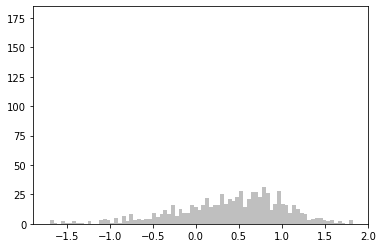

Gene RP11-538I12.2: SNR=3.4, pos=0, neg=187


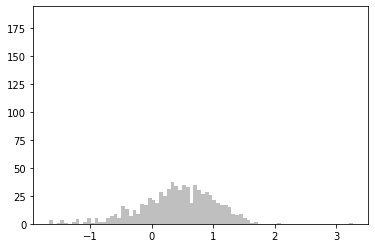

Gene AP000349.2: SNR=4.36, pos=0, neg=75


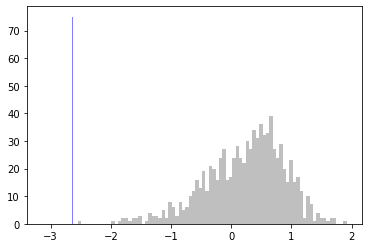

		genes processed: 11000
Gene LINC01291: SNR=3.42, pos=0, neg=349


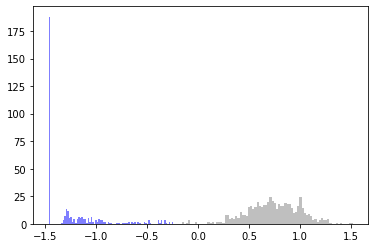

Gene DFFBP1: SNR=-3.09, pos=0, neg=144


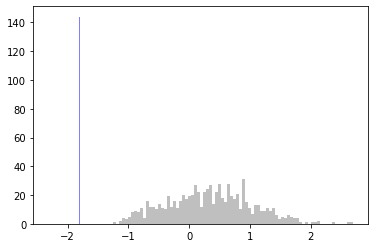

Gene RP11-977G19.10: SNR=-3.06, pos=0, neg=234


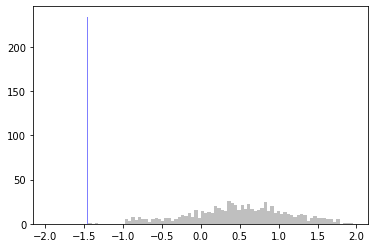

Gene CH507-396I9.7: SNR=3.87, pos=0, neg=84


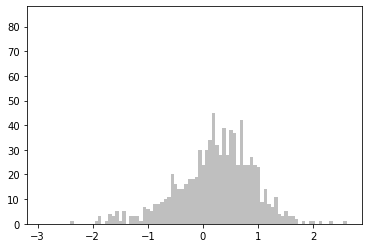

Gene XXbac-BPG116M5.17: SNR=3.53, pos=0, neg=161


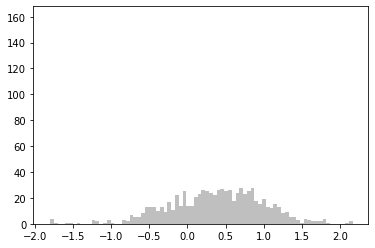

		genes processed: 12000
Gene AC068533.7: SNR=3.53, pos=0, neg=119


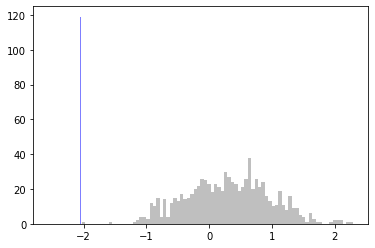

Gene CTD-2207O23.3: SNR=-3.22, pos=0, neg=366


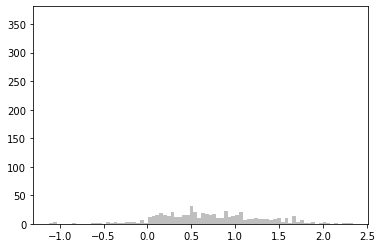

Gene RP11-104H15.10: SNR=3.14, pos=496, neg=449


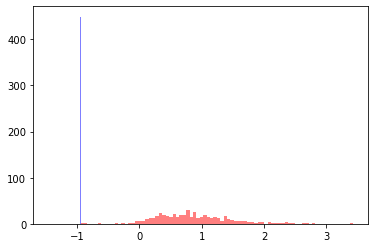

Gene RIMBP3B: SNR=3.03, pos=0, neg=287


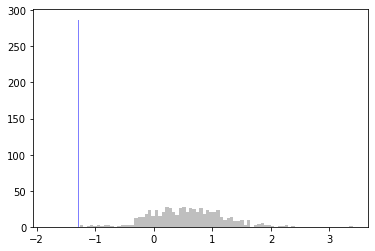

Gene RIMBP3C: SNR=-3.46, pos=0, neg=86


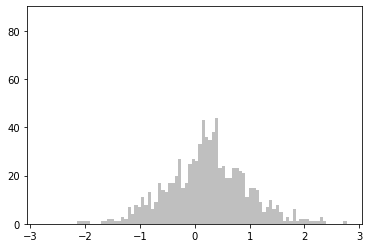

Gene TRIM39-RPP21: SNR=-3.23, pos=497, neg=448


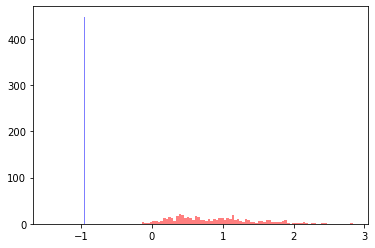

Gene RP11-20I23.10: SNR=3.19, pos=0, neg=145


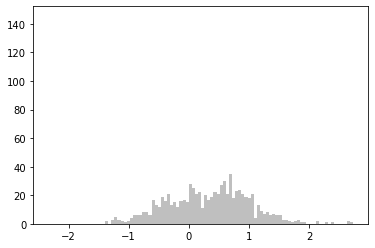

Gene RP11-334J6.7: SNR=-3.25, pos=0, neg=266


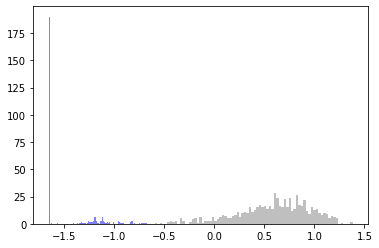

Gene RP11-265D17.2: SNR=4.02, pos=0, neg=72


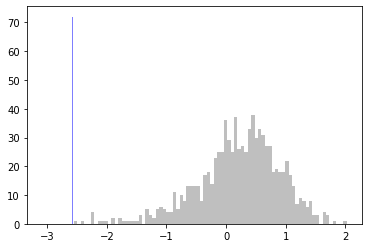

		genes processed: 13000
Gene RP4-734P14.4: SNR=3.46, pos=0, neg=113


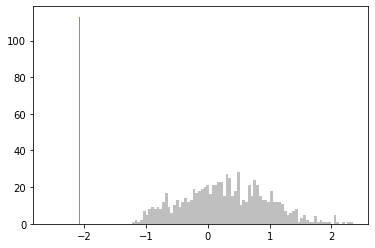

Gene CH507-9B2.4: SNR=-3.71, pos=513, neg=432


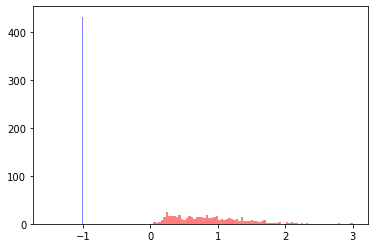

Gene AC006538.4: SNR=-3.01, pos=489, neg=456


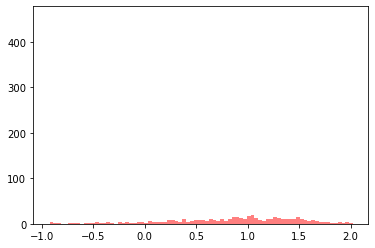

Gene C1QTNF3-AMACR: SNR=4.71, pos=0, neg=202


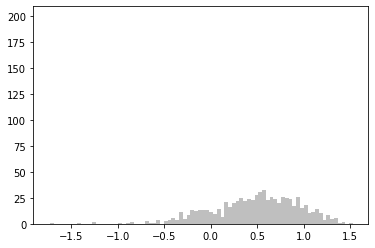

Gene RPL21P75: SNR=-3.39, pos=0, neg=324


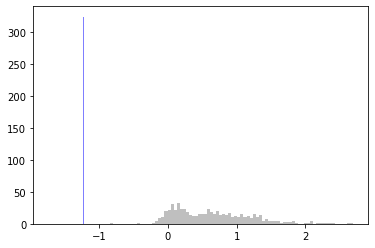

Gene RPL21P119: SNR=-3.13, pos=0, neg=289


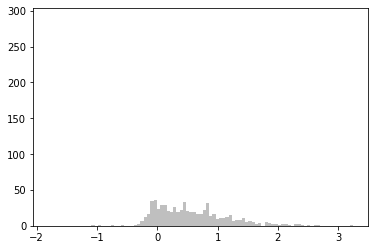

Gene CTD-3074O7.11: SNR=-5.38, pos=285, neg=0


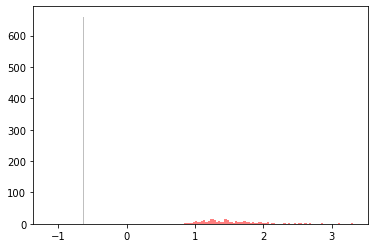

		genes processed: 14000
Gene RP11-225H22.7: SNR=-3.71, pos=0, neg=305


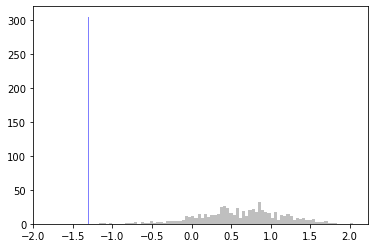

		genes processed: 15000
Gene RP11-158I13.2: SNR=-3.01, pos=0, neg=402


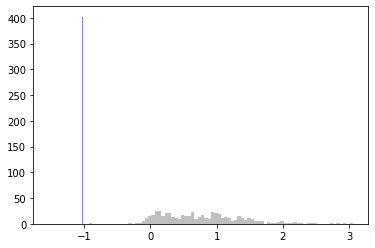

Gene GATA3: SNR=1.59, pos=0, neg=241


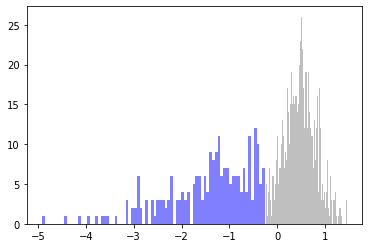

Gene RP11-360L9.8: SNR=3.83, pos=0, neg=99


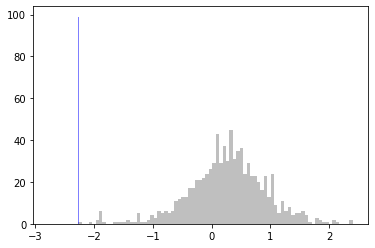

Gene AC018804.7: SNR=-3.04, pos=197, neg=0


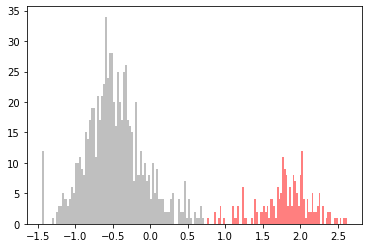

Gene RP11-529K1.3: SNR=3.22, pos=0, neg=315


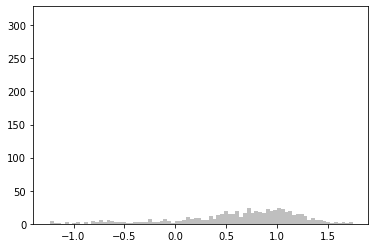

Gene RP13-582O9.6: SNR=3.04, pos=0, neg=140


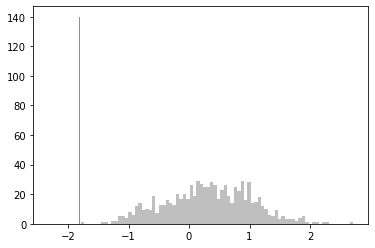

Gene ABHD16B: SNR=-3.31, pos=121, neg=0


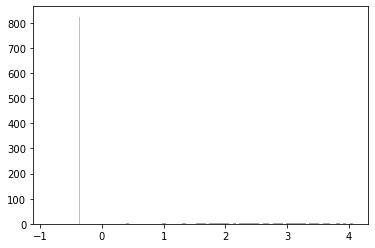

		genes processed: 16000
Gene RP11-474G23.2: SNR=5.83, pos=0, neg=160


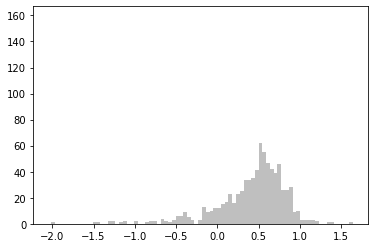

Gene FOXA1: SNR=2.24, pos=0, neg=175


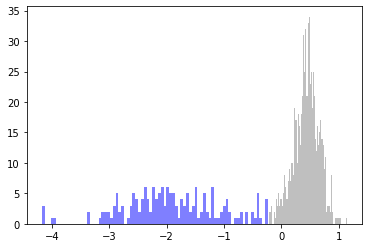

Gene RP11-514P8.8: SNR=4.77, pos=0, neg=86


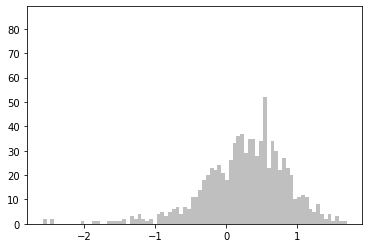

Gene SUMO2P1: SNR=-3.26, pos=0, neg=145


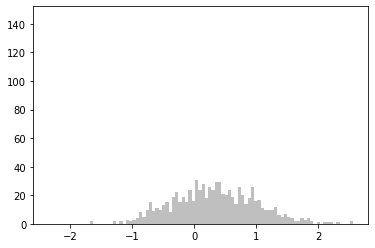

Gene RP11-369J21.12: SNR=3.29, pos=0, neg=262


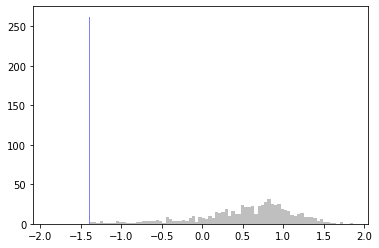

Gene TNFRSF6B: SNR=3.03, pos=0, neg=149


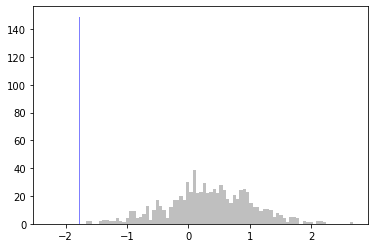

Gene HMGB1P3: SNR=-3.15, pos=0, neg=101


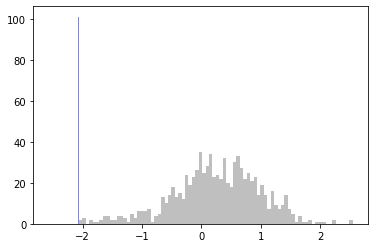

Gene CTB-59C6.3: SNR=-3.78, pos=0, neg=151


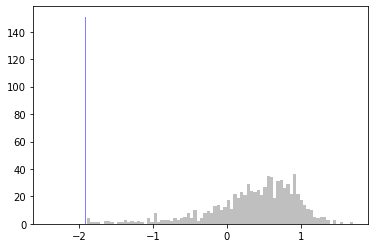

Gene RP11-750B16.1: SNR=-3.18, pos=112, neg=0


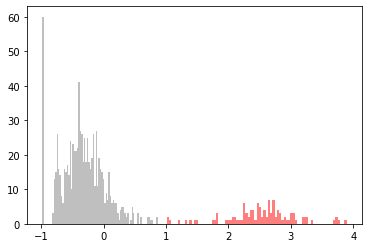

Gene RP11-442H21.2: SNR=3.32, pos=0, neg=186


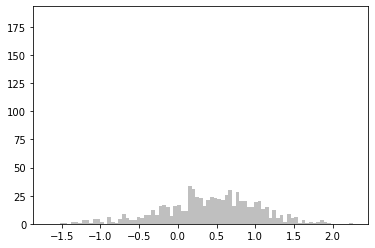

		genes processed: 17000
Gene RP11-690P14.4: SNR=-3.09, pos=0, neg=130


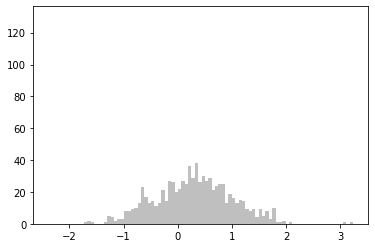

Gene ZRSR1: SNR=3.79, pos=0, neg=276


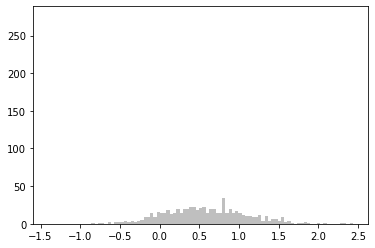

Gene RP11-248G5.8: SNR=-3.16, pos=0, neg=342


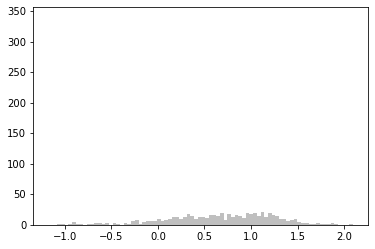

		genes processed: 18000
Gene CTD-3214H19.16: SNR=4.68, pos=208, neg=0


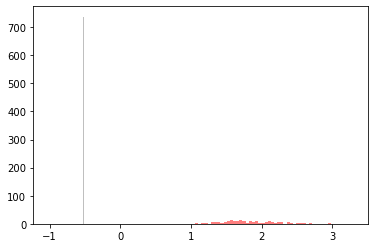

Gene IMPDH1P10: SNR=3.25, pos=0, neg=129


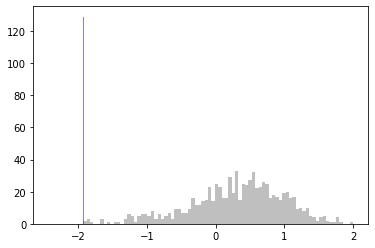

Gene RP11-579D7.2: SNR=3.26, pos=0, neg=163


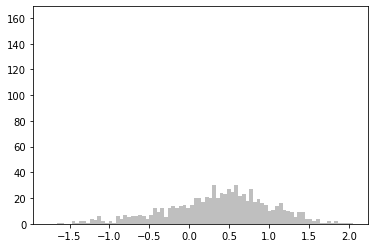

Gene ERBB2: SNR=-2.3, pos=90, neg=0


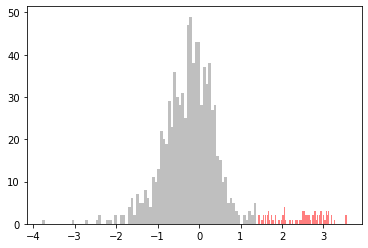

Gene TNFSF12-TNFSF13: SNR=3.19, pos=0, neg=230


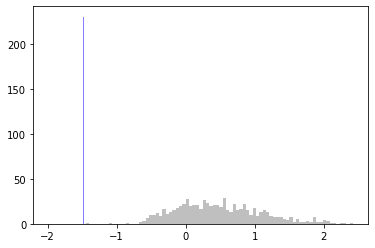

Gene PAPD7: SNR=-4.14, pos=0, neg=389


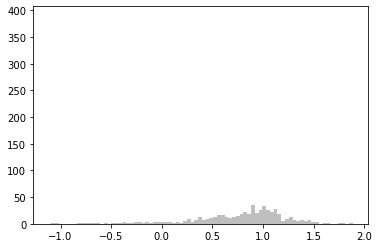

		genes processed: 19000
Gene ULK4P1: SNR=3.02, pos=0, neg=164


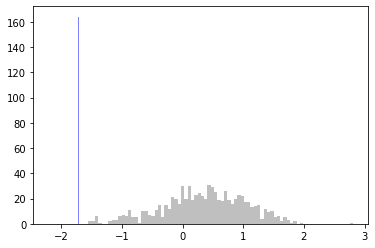

Gene RP11-108K14.8: SNR=-3.29, pos=0, neg=231


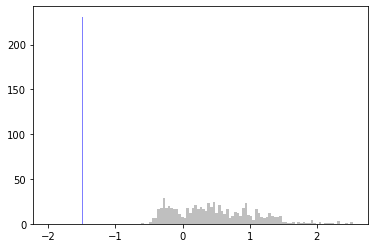

Gene GRB7: SNR=-2.17, pos=83, neg=0


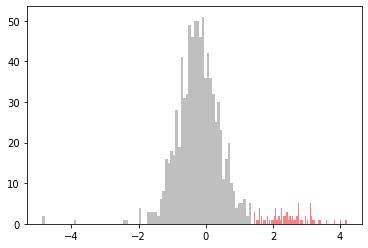

Gene AC010547.9: SNR=-4.62, pos=0, neg=63


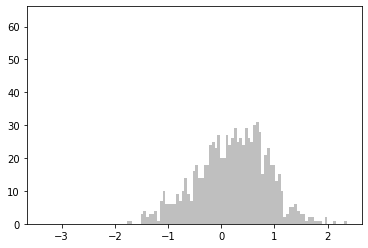

Gene RPL23AP25: SNR=-3.48, pos=0, neg=328


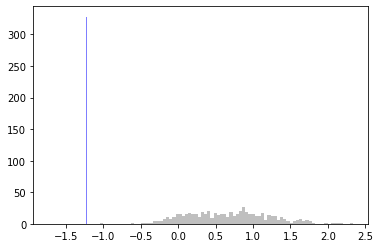

		genes processed: 20000
Gene PI4K2B: SNR=-3.33, pos=0, neg=367


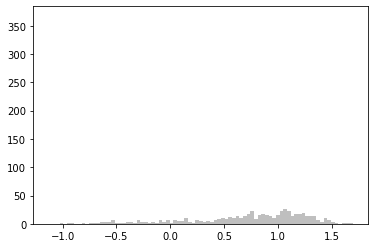

Gene TLR9: SNR=-3.39, pos=0, neg=206


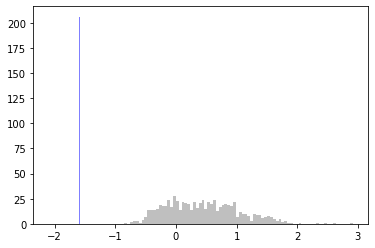

Gene ESR1: SNR=2.18, pos=0, neg=237


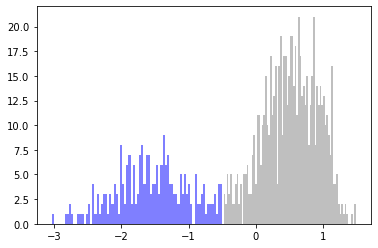

Gene BMS1P7: SNR=-3.03, pos=0, neg=409


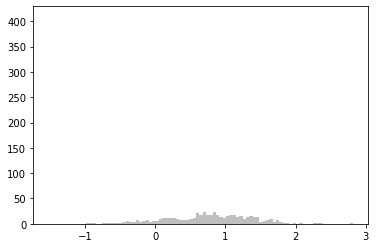

Gene CLDN22: SNR=-3.08, pos=241, neg=0


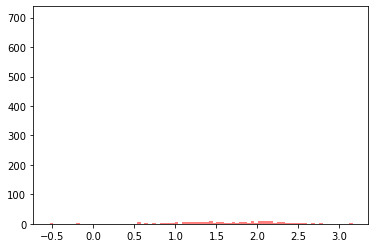

Gene CORO7-PAM16: SNR=3.5, pos=0, neg=242


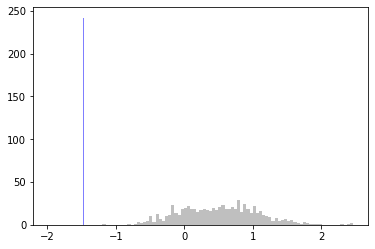

		genes processed: 21000
Gene CH17-408M7.1: SNR=3.04, pos=0, neg=187


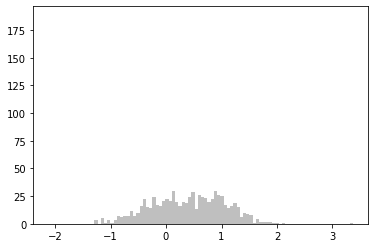

Gene RP11-20G6.1: SNR=3.26, pos=0, neg=89


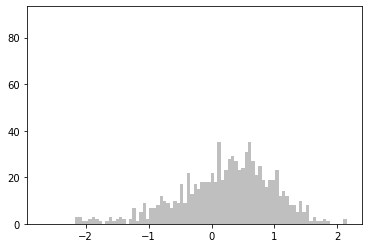

Gene CHURC1-FNTB: SNR=3.14, pos=0, neg=161


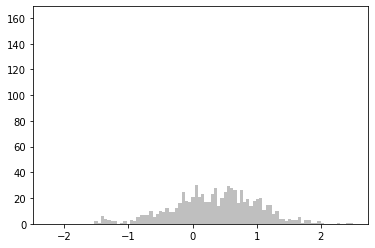

Gene RP11-464F9.1: SNR=4.9, pos=0, neg=86


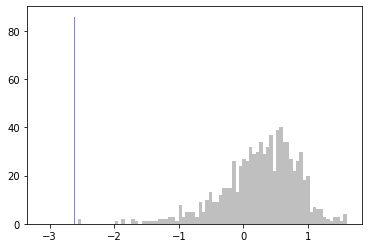

Gene AC005606.14: SNR=-3.25, pos=0, neg=182


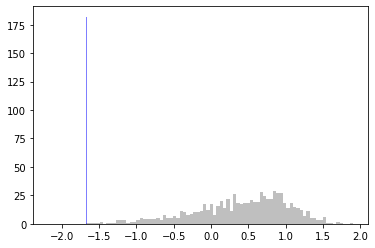

Gene AC005786.7: SNR=-3.08, pos=0, neg=268


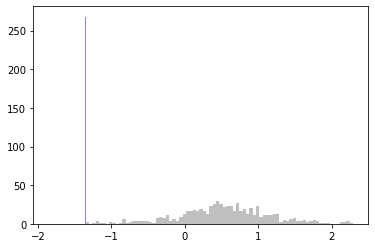

Gene RP11-463D19.2: SNR=3.45, pos=0, neg=306


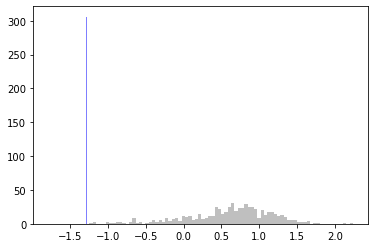

		genes processed: 22000
Gene GAPDHP62: SNR=3.38, pos=0, neg=81


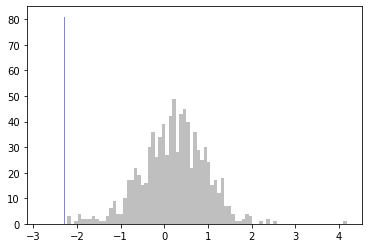

Gene RP11-138C9.1: SNR=3.75, pos=0, neg=109


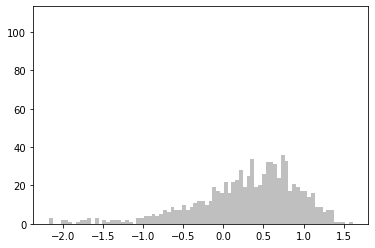

Gene XXbac-BPG246D15.9: SNR=4.18, pos=0, neg=67


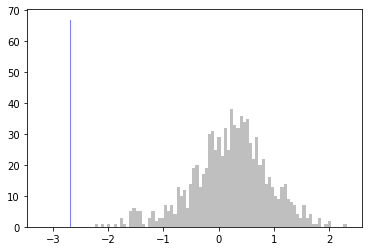

Gene RP11-746M1.1: SNR=3.32, pos=0, neg=103


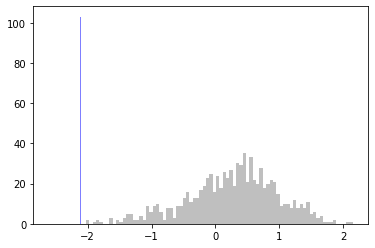

Gene SLC2A3P1: SNR=-3.41, pos=353, neg=0


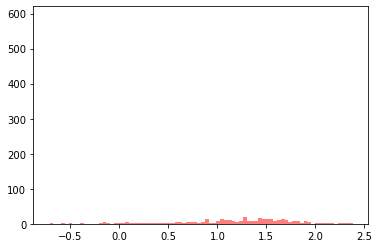

Gene RP11-837J7.4: SNR=3.54, pos=0, neg=99


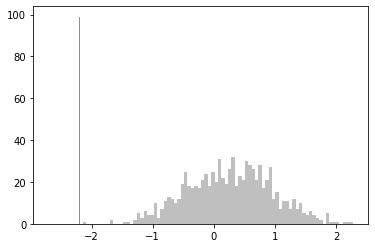

Gene CTD-2192J16.17: SNR=-3.06, pos=231, neg=0


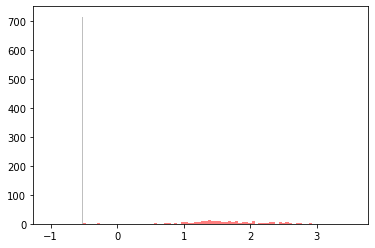

Gene CDH12P2: SNR=-4.64, pos=349, neg=0


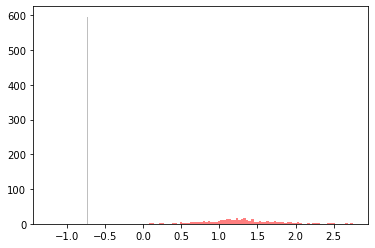

		genes processed: 23000
Gene AC084219.2: SNR=3.3, pos=0, neg=395


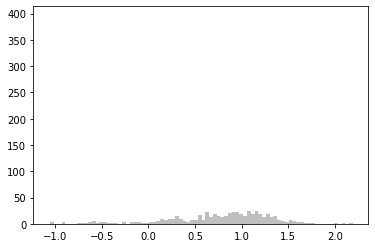

Gene RP11-493E12.3: SNR=3.01, pos=0, neg=171


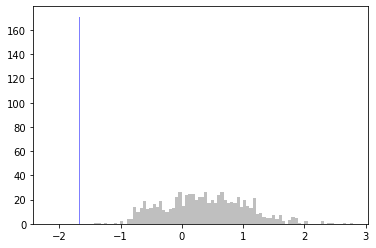

Gene RP11-449P15.1: SNR=3.73, pos=0, neg=131


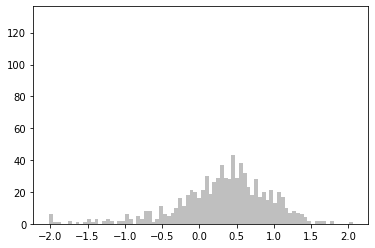

Gene MTND4P12: SNR=3.27, pos=0, neg=322


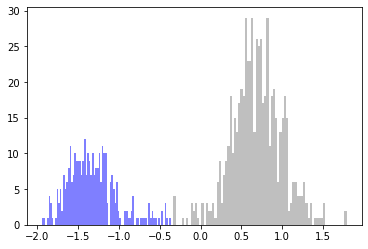

Gene RP11-745O10.4: SNR=-3.69, pos=0, neg=208


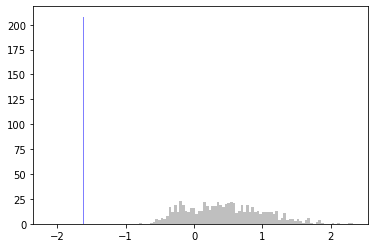

Gene BMPR1B: SNR=-1.88, pos=343, neg=0


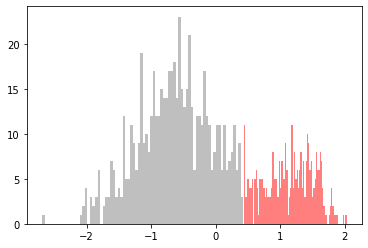

Gene IKBKGP1: SNR=3.47, pos=0, neg=144


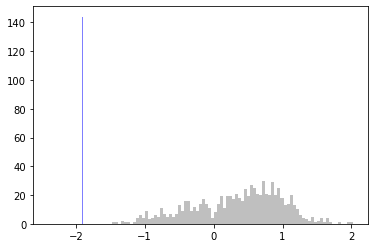

Gene RP11-473I1.9: SNR=5.51, pos=0, neg=213


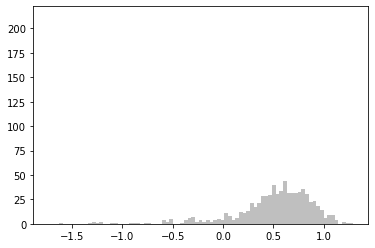

Total runtime 360.61 s for  23760 genes
	up-regulated genes: 2513
	down-regulated genes: 2979
	inexplicit genes: 800
Searching for UP-regulated biclusters ...
		KxN=2513x945
		p0= -655.0240856291483
	 1000 genes processed in  9.5 s
	 2000 genes processed in  13.9 s
time:	Initial state created in 14.3 s.
		LP matrix memory usage: 48.18M
step 1
1000 		genes processed in 71.7 s runtime...
2000 		genes processed in 62.7 s runtime...
	step  1 157.6 s
step 2
1000 		genes processed in 15.3 s runtime...
2000 		genes processed in 12.7 s runtime...
	step  2 35.7 s
step 3
1000 		genes processed in 3.5 s runtime...
2000 		genes processed in 5.2 s runtime...
	step  3 12.5 s
step 4
1000 		genes processed in 3.1 s runtime...
2000 		genes processed in 2.6 s runtime...
	step  4 7.7 s
step 5
1000 		genes processed in 3.1 s runtime...
2000 		genes processed in 2.6 s runtime...
	step  5 7.7 s
step 6
1000 		genes processed in 2.8 s runtime...
2000 		genes processed in 2.6 s runtime...
	step  6 7.3 s
step 7

/home/olya/TUM/DESMOND/DESMOND2/method2.py:697: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((sum_sq / count) - mean*mean)


time:	Identified optimal sample sets for 2513 modules in 36.19 s.
	Empty modules: 164
	Modules with just 1 edge: 164
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 1
Passed modules with >= 2 genes and >= 47 samples: 880
4x471	1.208	AL928768.3 CD79A FCRLA TNFRSF13B
67x238	0.792	AMD1 ARL9 ATP5C1 ATP6V1C2 BRI3 C9orf40 CCNE1 CDC123 CENPW CHEK1 CLTA COLGALT1 CTD-2527I21.15 CTPS1 DDN ECE2 EIF3B FAM136A GAL GARS GMPS GPR156 GPT2 GTPBP4 HMGA1 HPDL HSPA14 IMPA2 KCMF1 LDHB LYAR MAP7D2 MCM5 MED8 MTHFD1L NASP NT5DC2 PDCD5 PDIA6 PDSS1 PNO1 PNPT1 POR PRMT1 RBM17 RBM38 RHEB RIPK2 RPIA RRP1B SEPHS1 SH3GL3 SKP2 SNHG16 STOML2 SUV39H2 TIMM8A TIMMDC1 TMSB15A TOMM5 TPI1 UBALD2 UCK2 ULBP1 UQCRH WDR77 YARS
9x249	0.977	A2ML1 GJB3 KCNG1 PADI2 PSAT1 RAET1L SCEL SLC15A1 USB1
3x429	1.379	HERC2P4 HERC2P5 HERC2P8
4x350	0.663	ALOX15B CRYM SLC25A18 UGT2B11
4x291	0.753	MGAM PLA2G2C SHROOM1 TMC3
3x262	1.273	AC114730.3 GAL3ST2 NEU4
23x227	0.999	AC000089.3 AC009065.4 DTX2 FAM193

1000 		genes processed in 4.2 s runtime...
2000 		genes processed in 4.9 s runtime...
	step  31 14.2 s
	Converged: True #skipping edges slope: -0.03414
step 32
1000 		genes processed in 3.4 s runtime...
2000 		genes processed in 3.5 s runtime...
	step  32 11.2 s
	Converged: True #skipping edges slope: -0.00159
step 33
1000 		genes processed in 4.2 s runtime...
2000 		genes processed in 3.4 s runtime...
	step  33 12.3 s
	Converged: True #skipping edges slope: 0.0095
step 34
1000 		genes processed in 3.4 s runtime...
2000 		genes processed in 3.0 s runtime...
	step  34 10.4 s
	Converged: True #skipping edges slope: 0.01203
step 35
1000 		genes processed in 3.3 s runtime...
2000 		genes processed in 3.0 s runtime...
	step  35 10.4 s
	Converged: True #skipping edges slope: 0.00709
The model converged after 35 steps.
Consensus of last 15 states will be taken
Sampling runtime 668.3 s
time:	Sampling (36 steps) fininshed in 668.26 s.
	edge: 1394 counts: [6 5 4] 
	labels: 1190,1342,1989
	edge: 

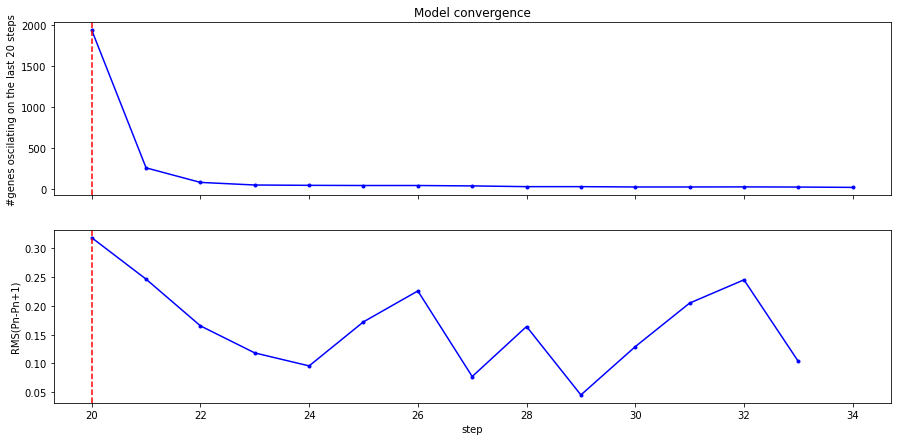

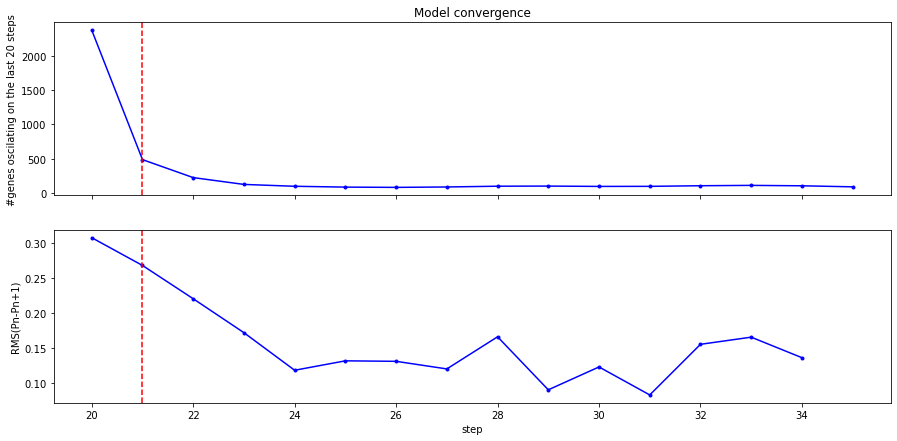

In [8]:
exprs_file = "../datasets/TCGA-BRCA_945.Xena.log2RSEM_norm_z.24K_genes.tsv"
basename= "TCGA-RNAseq_24K+0.005"
bics4 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed, snr_pval=0.005)